# Мастерская BigData pySpark ChicagoTaxiDispatching

## Описание проекта

В нашем распоряжении данные о примерно 10 миллионах поездок в Чикаго за 2022 и 2023 годы и перед нами стоит задача предсказать количество заказов на следующий час в каждом округе.

Работа над проектом проводится на локально развёрнутом Spark-кластере из Docker-контейнеров.

Бизнес метрика - минимальное время простоя машин такси в ожидании клиента, а также минимальное время простоя клиента в ожидании машины. Бизнес метрика будет максимальной если мы максимально точно предскажем количество заказов для каждого округа, поэтому наша целевая метрика в задачах машинного обучения - MAE.

## Описание данных

Данные взяты с Chicago Data Portal:
  * https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz
  * https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb

В нашем распоряжении данные о поездках в Чикаго за 2022 и 2023 годы.

Описание данных по колонкам:
  * **trip_id** *text* - уникальный идентификатор поездки
  * **taxi_id** *text* - уникальный идентификатор машины такси
  * **trip_start_timestamp** *timestamp* - время старта поездки, окрглённое к ближайшим 15 минутам
  * **trip_end_timestamp** *timestamp* - время окончания поездки, окрглённое к ближайшим 15 минутам
  * **trip_seconds** *number* - длительность поездки в секундах
  * **trip_miles** *number* - расстояние поездки в милях
  * **pickup_census_tract** *text* - название зоны посадки. Может отсутствовать в некоторых записях из соображений приватности. Часто отсутствует для локаций вне Чикаго.
  * **dropoff_census_tract** *text* - название зоны высадки
  * **pickup_community_area** *number* - номер района посадки в Чикаго. Может быть пустым если поездка началась вне Чикаго.
  * **dropoff_community_area** *number* - номер района высадки в Чикаго
  * **fare** *number* - стоимость поездки
  * **tips** *number* - чаевые водителю. Чаевые наличными не указываются.
  * **tolls** *number* - сборы за платные участки дороги
  * **extras** *number* - дополнительные сборы за поездку
  * **trip_total** *number* - общая стоимость поездки
  * **payment_type** *text* - тип оплаты
  * **company** *text* - название компании такси
  * **pickup_centroid_latitude** *number* - широта центра зоны посадки или номера района, если зона скрыта. Часто отсутствует вне Чикаго.
  * **pickup_centroid_longitude** *number* - долгота центра зоны посадки или номера района, если зона скрыта. Часто отсутствует вне Чикаго.
  * **pickup_centroid_location** *point* - координаты центра зоны посадки или номера района, если зона скрыта. Часто отсутствует вне Чикаго.
  * **dropoff_centroid_latitude** *number* - широта центра зоны высадки или номера района, если зона скрыта. Часто отсутствует вне Чикаго.
  * **dropoff_centroid_longitude** *number* - долгота центра зоны высадки или номера района, если зона скрыта. Часто отсутствует вне Чикаго.
  * **dropoff_centroid_location** *point* - координаты центра зоны высадки или номера района, если зона скрыта. Часто отсутствует вне Чикаго.

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext, Window

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 25)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Объявим глобальные переменные и зафиксируем рандомайзеры.

In [4]:
SEED=31416
np.random.seed=SEED
np.random.set_state=SEED

Создаём сессию.

In [5]:
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

In [6]:
spark

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=spark://172.18.0.2:7077 appName=pyspark-taxi-forecasting>

## Загрузка данных из файла в DataFrame

Укажем путь до файла с данными.

In [8]:
TAXI_DATA_22 = 'Taxi_Trips_-_2022.csv'
TAXI_DATA_23 = 'Taxi_Trips_-_2023.csv'

Для ускорения обработки напрямую укажем типы данных.

In [9]:
schema = StructType([
    StructField('trip_id', StringType(), nullable=True),
    StructField('taxi_id', StringType(), nullable=True),
    StructField('trip_start_timestamp', StringType(), nullable=True),
    StructField('trip_end_timestamp', StringType(), nullable=True),
    StructField('trip_seconds', IntegerType(), nullable=True),
    StructField('trip_miles', FloatType(), nullable=True),
    StructField('pickup_census_tract', StringType(), nullable=True),
    StructField('dropoff_census_tract', StringType(), nullable=True),
    StructField('pickup_community_area', IntegerType(), nullable=True),
    StructField('dropoff_community_area', IntegerType(), nullable=True),
    StructField('fare', FloatType(), nullable=True),
    StructField('tips', FloatType(), nullable=True),
    StructField('tolls', FloatType(), nullable=True),
    StructField('extras', FloatType(), nullable=True),
    StructField('trip_total', FloatType(), nullable=True),
    StructField('payment_type', StringType(), nullable=True),
    StructField('company', StringType(), nullable=True),
    StructField('pickup_centroid_latitude', FloatType(), nullable=True),
    StructField('pickup_centroid_longitude', FloatType(), nullable=True),
    StructField('pickup_centroid_location', StringType(), nullable=True),
    StructField('dropoff_centroid_latitude', FloatType(), nullable=True),
    StructField('dropoff_centroid_longitude', FloatType(), nullable=True),
    StructField('dropoff_centroid_location', StringType(), nullable=True)
])

In [10]:
df = spark.read.csv(path=[TAXI_DATA_22, TAXI_DATA_23], schema=schema, header=True)

Посмотрим на данные.

In [11]:
df.limit(5).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,bcfa19f2539021c054809...,368ce5511598af2cc07ef...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152,0.100000,None,None,NaN,NaN,3.75,0.00,0.0,0.0,3.75,Cash,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
1,2aba69ff015f9ea8e7bff...,449fa4909552757130d09...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360,17.440001,None,None,NaN,8.0,47.75,0.00,0.0,5.0,52.75,Cash,Flash Cab,NaN,NaN,None,41.899601,-87.633308,POINT (-87.6333080367...
2,54d812a0b88f8f9707825...,f98ae5e71fdda8806710a...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536,4.830000,None,None,28.0,22.0,14.75,0.00,0.0,0.0,14.75,Cash,Globe Taxi,41.874004,-87.663521,POINT (-87.6635175498...,41.922760,-87.699158,POINT (-87.6991553432...
3,7125b9e03a0f16c2dfb5e...,8eca35a570101ad24c638...,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897,2.070000,None,None,8.0,32.0,9.75,0.00,0.0,1.5,11.25,Cash,Sun Taxi,41.899601,-87.633308,POINT (-87.6333080367...,41.878864,-87.625191,POINT (-87.6251921424...
4,f1a650ee419b4e52d7664...,e2d8418fcdb061eee0a43...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200,2.480000,None,None,8.0,32.0,9.36,2.14,0.0,0.0,11.50,Mobile,Chicago Independents,41.899601,-87.633308,POINT (-87.6333080367...,41.878864,-87.625191,POINT (-87.6251921424...


In [12]:
df.tail(5)

[Row(trip_id='f5ba11ba1d2f0dd11c598d05481947e19c8e1a17', taxi_id='0cbf5c0f6aca3628d77c7b6fe89715757ed402a70b0f8b546f175f2f0f8b051cbf2586f93f658f5b91675cbcec559ff886c7b477bf25fbc1f32c4e252f3f3435', trip_start_timestamp='12/31/2022 11:45:00 PM', trip_end_timestamp='12/31/2022 11:45:00 PM', trip_seconds=539, trip_miles=1.850000023841858, pickup_census_tract=None, dropoff_census_tract=None, pickup_community_area=32, dropoff_community_area=28, fare=11.479999542236328, tips=0.0, tolls=0.0, extras=0.0, trip_total=11.479999542236328, payment_type='Mobile', company='Globe Taxi', pickup_centroid_latitude=41.87886428833008, pickup_centroid_longitude=-87.62519073486328, pickup_centroid_location='POINT (-87.6251921424 41.8788655841)', dropoff_centroid_latitude=41.87400436401367, dropoff_centroid_longitude=-87.66352081298828, dropoff_centroid_location='POINT (-87.6635175498 41.874005383)'),
 Row(trip_id='f8fad61a583724263dcc628c822ec835f212665d', taxi_id='081758ced4767105bfa217f7b0784d72d37e12a016fe

Посмотрим на схему таблицы.

In [13]:
df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: float (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: string (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: float (nullable = true)
 |-- tips: float (nullable = true)
 |-- tolls: float (nullable = true)
 |-- extras: float (nullable = true)
 |-- trip_total: float (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: float (nullable = true)
 |-- pickup_centroid_longitude: float (nullable = true)
 |-- pickup_centroid_location: string (nullable = true)
 |-- dropoff_centroid_latitude: float (nullable = true)
 |-- dropoff_centroid_longi

Посчитаем количество строк.

In [14]:
df.count()

10166155

Создадим стратифицированную выборку для работы с датасетом. Стратификацию проведём по колонке с временем начала поездки `trip_start_timestamp`.

In [15]:
# Создадим словарь с ключами - уникальными временами стартов поездок и значениями в виде константы
fractions = df.select('trip_start_timestamp').distinct().withColumn('fraction', F.lit(0.005)).rdd.collectAsMap()
# ОТберём строки
sampled_df = df.sampleBy('trip_start_timestamp', fractions, SEED).cache()

Заново посчитаем количество строк в семплированном датасете.

In [16]:
sampled_df.count()

50459

Посмотрим на статистики.

In [17]:
sampled_df.summary().toPandas()

,summary,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,count,50459,50459,50459,50457,50446,50459,21128,21192,47081,45455,50416,50416,50416,50416,50416,50459,50459,47096,47096,47096,45745,45745,45745
1,mean,None,None,None,None,1227.892023153471,6.37375750546666,1.703148470929558E10,1.7031410540925726E10,33.49149338374291,25.813419865801343,22.17679626333157,2.844495796702237,0.12800102754313822,2.1898010514087067,27.49493434644536,None,None,41.90048431609024,-87.6927114601388,None,41.89419999084573,-87.66198915428824,None
2,stddev,None,None,None,None,1931.5761862899337,8.693521935169386,370773.0398129945,344056.08101920685,25.546093764172742,20.824236967810958,57.422283509403066,4.102556047032736,25.236319429215932,19.37946552734635,73.56611845200567,None,None,0.06149769111093362,0.10794783759686412,None,0.056780439764059686,0.07274641231927213,None
3,min,00058068a776934b3f477...,0041f8f0c91881c1e1913...,01/01/2022 01:00:00 AM,01/01/2022 01:00:00 AM,0,0.0,17031010501,17031010100,1,1,0.0,0.0,0.0,0.0,0.0,Cash,24 Seven Taxi,41.660137,-87.91363,POINT (-87.5349029012...,41.660137,-87.91363,POINT (-87.5349029012...
4,25%,None,None,None,None,467,0.9,1.70310816E10,1.70310815E10,8,8,8.0,0.0,0.0,0.0,10.0,None,None,41.878864,-87.69916,None,41.878864,-87.66352,None
5,50%,None,None,None,None,900,2.76,1.70313201E10,1.70313201E10,32,28,14.43,1.0,0.0,0.0,17.5,None,None,41.895035,-87.63331,None,41.89251,-87.63331,None
6,75%,None,None,None,None,1670,11.4,1.7031841E10,1.70318391E10,56,32,33.75,4.0,0.0,2.5,41.71,None,None,41.947792,-87.62519,None,41.922688,-87.62519,None
7,max,ffff8feb8b7f0f061b37f...,fff84aa08ac78890c6e7d...,12/31/2022 12:45:00 PM,12/31/2022 12:45:00 PM,86340,931.8,17031980100,17031980100,77,77,8600.23,80.0,5664.55,4144.55,9822.35,Unknown,U Taxicab,42.009624,-87.534904,POINT (-87.913624596 ...,42.021225,-87.534904,POINT (-87.913624596 ...


In [18]:
sampled_df.limit(5).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,16d204040edb3275a6233...,e8ebe1fb12cc70947d403...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,1559,12.39,None,None,48,67,34.250000,0.00,0.0,0.0,34.25,Prcard,Flash Cab,41.729675,-87.572716,POINT (-87.5727171342...,41.775928,-87.666595,POINT (-87.6665962653...
1,29ca900a376c3bfcddfd5...,c3fe9312c9722befcf39d...,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,631,2.96,None,None,8,24,10.500000,0.00,0.0,0.0,11.00,Credit Card,City Service,41.899601,-87.633308,POINT (-87.6333080367...,41.901207,-87.676353,POINT (-87.6763559892...
2,8bb7e3088967aad924645...,8f4cde3f6d55c38289233...,01/01/2022 12:30:00 AM,01/01/2022 12:30:00 AM,701,3.35,None,None,6,24,11.000000,1.88,0.0,1.0,14.38,Credit Card,Chicago Independents,41.944225,-87.655998,POINT (-87.6559981815...,41.901207,-87.676353,POINT (-87.6763559892...
3,d52d2da41bcf75fa806e0...,fb61583f0b732a39f08c0...,01/01/2022 12:30:00 AM,01/01/2022 12:30:00 AM,587,4.97,None,None,8,21,18.030001,4.07,0.0,0.0,22.10,Mobile,Sun Taxi,41.899601,-87.633308,POINT (-87.6333080367...,41.938667,-87.711212,POINT (-87.7112105933...
4,aa172ea0eefaf24bef38a...,6fe3a00b45ce19e32d13d...,01/01/2022 01:00:00 AM,01/01/2022 01:00:00 AM,352,1.30,None,None,8,7,6.500000,2.00,0.0,0.0,9.00,Credit Card,City Service,41.899601,-87.633308,POINT (-87.6333080367...,41.922688,-87.649490,POINT (-87.6494887289...


## EDA

### Дубликаты, пропуски, нулевые значения

Проверим наличие дубликатов в данных.

In [19]:
sampled_df.distinct().count()

50459

В сэмплированном датасете дубликатов нет, проверим количество пропусков по колонкам.

In [20]:
sampled_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in sampled_df.columns]).show()

+-------+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+-------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|trip_id|taxi_id|trip_start_timestamp|trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area|fare|tips|tolls|extras|trip_total|payment_type|company|pickup_centroid_latitude|pickup_centroid_longitude|pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|dropoff_centroid_location|
+-------+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+-------+----------------------

В большинстве колонок небольшое количество пропусков. В колонках с локациями забора и высадки пассажиров отсутствует около 10% данных. С условием наличия большого количества данных можно отбросить.

Также много пропусков ~60% в колонках `pickup_census_tract` и `dropoff_census_tract`, но т.к. они неинформативные, мы полностью отбросим эти столбцы.

Есть смысл отбросить колонки с данными `trip_id`, `taxi_id`, т.к. уникальные данные по каждой поездке не принесут обобщённой информации для моделей.

Удалим также колонки `pickup_centroid_location`, `dropoff_centroid_location`, т.к. они являются дублями соответствующих колонок.

Колонку `trip_total` удалим в связи с коллинеарностью с другими колонками (она является суммой отдельных составляющих цены поездки).

In [21]:
columns_to_drop = ['trip_id', 'taxi_id', 'pickup_census_tract', 'dropoff_census_tract', 'trip_total', 'pickup_centroid_location', 'dropoff_centroid_location']

In [22]:
sampled_df = sampled_df.drop(*columns_to_drop)

Колонки `trip_start_timestamp` и `trip_end_timestamp` отображаются как текст, переведём в timestamp.

In [23]:
sampled_df = sampled_df.withColumn('trip_start_timestamp', F.to_timestamp(col('trip_start_timestamp'),'MM/dd/yyyy hh:mm:ss a'))
sampled_df = sampled_df.withColumn('trip_end_timestamp', F.to_timestamp(col('trip_end_timestamp'),'MM/dd/yyyy hh:mm:ss a'))

Проверим результат.

In [24]:
sampled_df.limit(5).toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
0,2022-01-01 00:00:00,2022-01-01 00:30:00,1559,12.39,48,67,34.250000,0.00,0.0,0.0,Prcard,Flash Cab,41.729675,-87.572716,41.775928,-87.666595
1,2022-01-01 00:00:00,2022-01-01 00:15:00,631,2.96,8,24,10.500000,0.00,0.0,0.0,Credit Card,City Service,41.899601,-87.633308,41.901207,-87.676353
2,2022-01-01 00:30:00,2022-01-01 00:30:00,701,3.35,6,24,11.000000,1.88,0.0,1.0,Credit Card,Chicago Independents,41.944225,-87.655998,41.901207,-87.676353
3,2022-01-01 00:30:00,2022-01-01 00:30:00,587,4.97,8,21,18.030001,4.07,0.0,0.0,Mobile,Sun Taxi,41.899601,-87.633308,41.938667,-87.711212
4,2022-01-01 01:00:00,2022-01-01 01:00:00,352,1.30,8,7,6.500000,2.00,0.0,0.0,Credit Card,City Service,41.899601,-87.633308,41.922688,-87.649490


Проверим количество пропусков по оставшимся колонкам и ибавимся от строк с пропусками.

In [25]:
sampled_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in sampled_df.columns]).show()

+--------------------+------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+-------+------------------------+-------------------------+-------------------------+--------------------------+
|trip_start_timestamp|trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|fare|tips|tolls|extras|payment_type|company|pickup_centroid_latitude|pickup_centroid_longitude|dropoff_centroid_latitude|dropoff_centroid_longitude|
+--------------------+------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+-------+------------------------+-------------------------+-------------------------+--------------------------+
|                   0|                 2|          13|         0|                 3378|                  5004|  43|  43|   43|    43|           0|      0|                    3363|                     3363|                  

In [26]:
sampled_df = sampled_df.dropna()

In [27]:
sampled_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in sampled_df.columns]).show()

+--------------------+------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+-------+------------------------+-------------------------+-------------------------+--------------------------+
|trip_start_timestamp|trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|fare|tips|tolls|extras|payment_type|company|pickup_centroid_latitude|pickup_centroid_longitude|dropoff_centroid_latitude|dropoff_centroid_longitude|
+--------------------+------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+-------+------------------------+-------------------------+-------------------------+--------------------------+
|                   0|                 0|           0|         0|                    0|                     0|   0|   0|    0|     0|           0|      0|                       0|                        0|                  

In [28]:
sampled_df.count()

43698

Избавились от пропусков. Проверим ещё раз общую статистику.

In [29]:
sampled_df.summary().toPandas()

,summary,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
0,count,43698,43698,43698,43698,43698,43698,43698,43698,43698,43698,43698,43698,43698,43698
1,mean,1158.2368987139,5.659150533147308,31.580964803881184,25.829420110760218,20.443285515228062,2.5646603983441643,0.1347766443467255,1.3201034327840993,None,None,41.89785051937261,-87.68328157440902,41.89339914077032,-87.66036221362224
2,stddev,1659.9985891034503,6.995302503814677,24.509436927235704,20.79951282033003,60.647188027902445,3.6938237668808083,27.101676018467906,20.127397460903836,None,None,0.05947694812997879,0.10068935881146675,0.05643972959386445,0.07069326027881628
3,min,0,0.0,1,1,0.0,0.0,0.0,0.0,Cash,24 Seven Taxi,41.660137,-87.91363,41.660137,-87.91363
4,25%,441,0.83,8,8,7.75,0.0,0.0,0.0,None,None,41.878864,-87.6725,41.878864,-87.663414
5,50%,840,2.3,32,28,12.75,1.0,0.0,0.0,None,None,41.89251,-87.63331,41.89251,-87.63331
6,75%,1562,10.16,41,32,30.75,3.45,0.0,1.0,None,None,41.944225,-87.62519,41.922688,-87.62519
7,max,77797,535.83,77,77,8600.23,80.0,5664.55,4144.55,Unknown,U Taxicab,42.009624,-87.534904,42.021225,-87.534904


Есть нулевые значения как по километражу поездок так и по времени, посмотрим сколько их.

In [30]:
sampled_df.select('trip_seconds', 'trip_miles').filter((col('trip_seconds') == 0) | (col('trip_miles') == 0)).count()

5253

Значительное количество, проверим что встречается чаще.

In [31]:
sampled_df.select('trip_seconds', 'trip_miles').filter((col('trip_seconds') == 0) & (col('trip_miles') != 0)).count()

48

In [32]:
sampled_df.filter((col('trip_seconds') == 0) & (col('trip_miles') != 0)).show(5)

+--------------------+-------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
|trip_start_timestamp| trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|fare|tips|tolls|extras|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|dropoff_centroid_latitude|dropoff_centroid_longitude|
+--------------------+-------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
| 2022-01-02 05:45:00|2022-01-02 05:45:00|           0|       0.1|                   28|                    28|4.25| 0.0|  0.0|  42.0|        Cash|Taxi Affiliation ...|             

Вероятно, ошибочно занесённые данные, т.к. за 0 секунд невозможно проехать 0.1 мили, и тем более 15.8, да ещё и в рамках одного района. Данные лучше будет сбросить при фильтрации.

In [33]:
sampled_df = sampled_df.filter(~((col('trip_seconds') == 0) & (col('trip_miles') != 0)))
sampled_df.count()

43650

In [34]:
sampled_df.select('trip_seconds', 'trip_miles').filter((col('trip_seconds') != 0) & (col('trip_miles') == 0)).count()

4350

In [35]:
sampled_df.filter((col('trip_seconds') != 0) & (col('trip_miles') == 0)).show()

+--------------------+-------------------+------------+----------+---------------------+----------------------+-----+-----+-----+------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
|trip_start_timestamp| trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area| fare| tips|tolls|extras|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|dropoff_centroid_latitude|dropoff_centroid_longitude|
+--------------------+-------------------+------------+----------+---------------------+----------------------+-----+-----+-----+------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
| 2022-01-01 02:45:00|2022-01-01 02:45:00|          82|       0.0|                   31|                    31|16.67| 3.77|  0.0|   0.0|      Mobile|           Flash Cab|     

Данные содержат как записи с одним и тем же районом начала и конца поездки, что, вероятно, является заказом без поездки (клиент не совершил посадку, но были сняты деньги за вызов/ожидание).
Так и данные с разным районом посадки/высадки при условии нулевого километража, вероятно, тут неверно были внесены данные по поездкам.

Для заполнения расстояния можно было бы использовать усреднённые данные по поездкам с теми же районами посадки/высадки и временем поездки (для учёта часов пик). Если примем решение использовать эти даныне как признаки - можно будет заполнить данные. Пока оставим как есть.

Проверим последнее сочетание, когда и время поездки и расстояние равны 0.

In [36]:
sampled_df.select('trip_seconds', 'trip_miles').filter((col('trip_seconds') == 0) & (col('trip_miles') == 0)).count()

855

In [37]:
sampled_df.filter((col('trip_seconds') == 0) & (col('trip_miles') == 0)).show()

+--------------------+-------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
|trip_start_timestamp| trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|fare|tips|tolls|extras|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|dropoff_centroid_latitude|dropoff_centroid_longitude|
+--------------------+-------------------+------------+----------+---------------------+----------------------+----+----+-----+------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
| 2022-01-01 03:30:00|2022-01-01 03:30:00|           0|       0.0|                    8|                     8|3.25| 0.0|  0.0|   0.0|        Cash|Taxi Affiliation ...|             

Дополнительно проверим количество поездок у которых время старта и финиша отличается.

In [38]:
sampled_df.filter((col('trip_seconds') == 0) & (col('trip_miles') == 0) & (col('trip_start_timestamp') != col('trip_end_timestamp'))).count()

0

Таких не оказалось. Вероятно, это отменённые поездки. Т.к. проверка показала что машина не ожидает значительное время клиента, можно предположить что данные поездки не влияют на спрос на машины и избавиться от этой части данных.

In [39]:
sampled_df = sampled_df.filter(~((col('trip_seconds') == 0) & (col('trip_miles') == 0)))
sampled_df.count()

42795

### Выбросы

Посмотрим на выпадающие значения.

<Axes: >

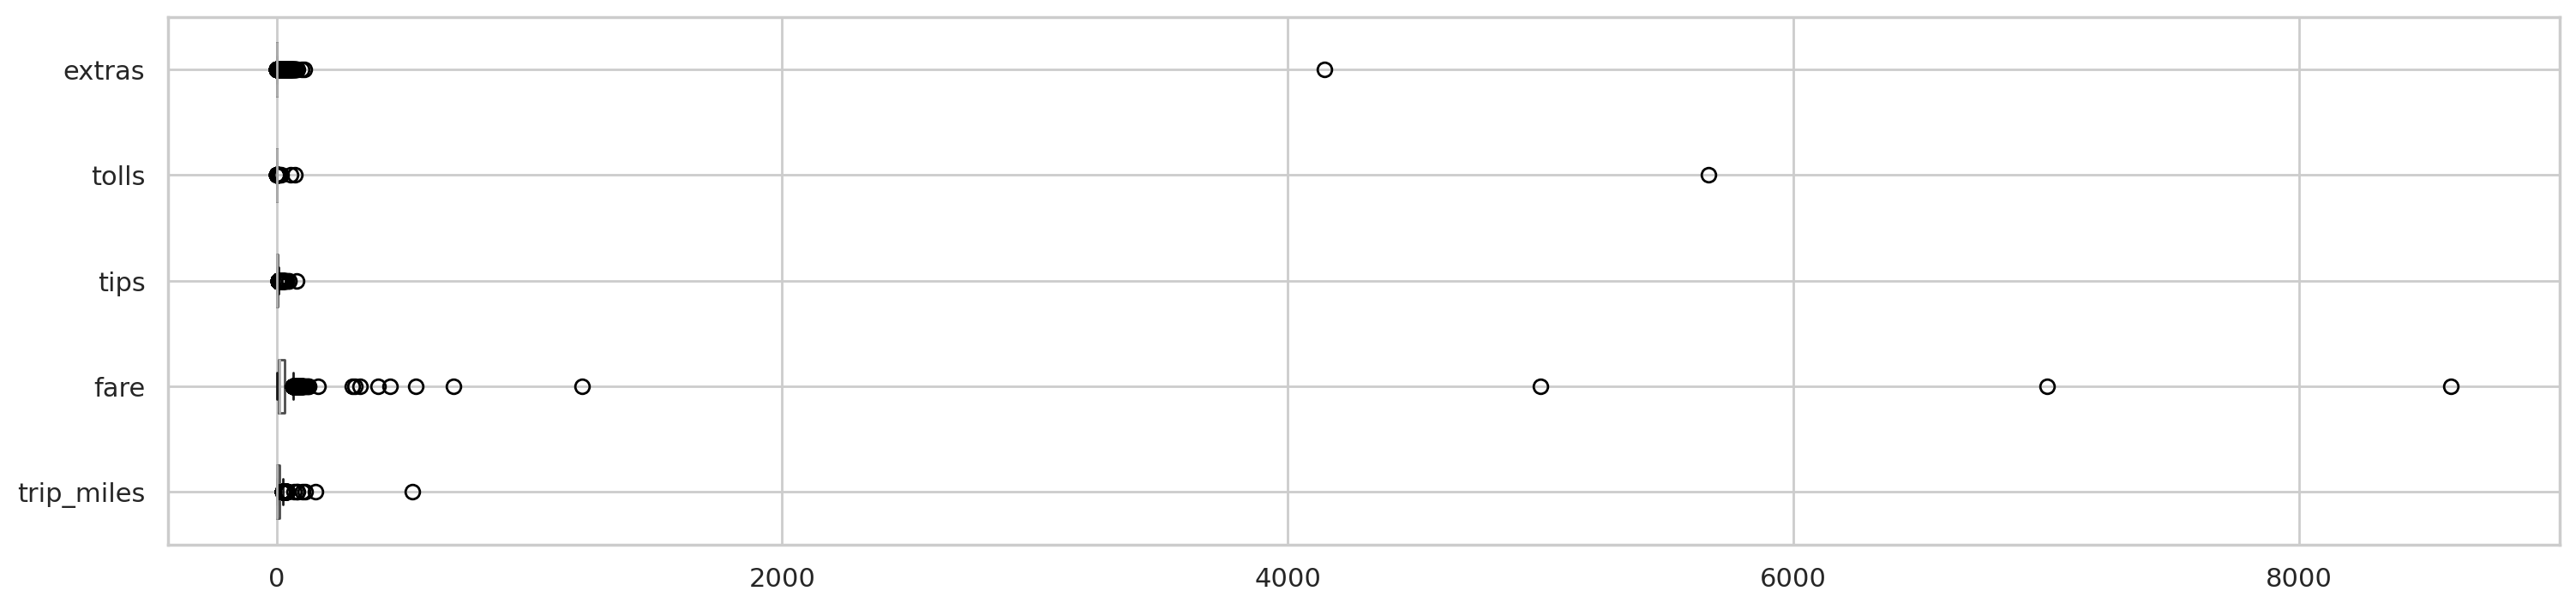

In [40]:
columns_to_filter = ['trip_miles', 'fare', 'tips', 'tolls', 'extras']
sampled_df.select(*columns_to_filter).toPandas().boxplot(column=columns_to_filter, vert=False)

<Axes: >

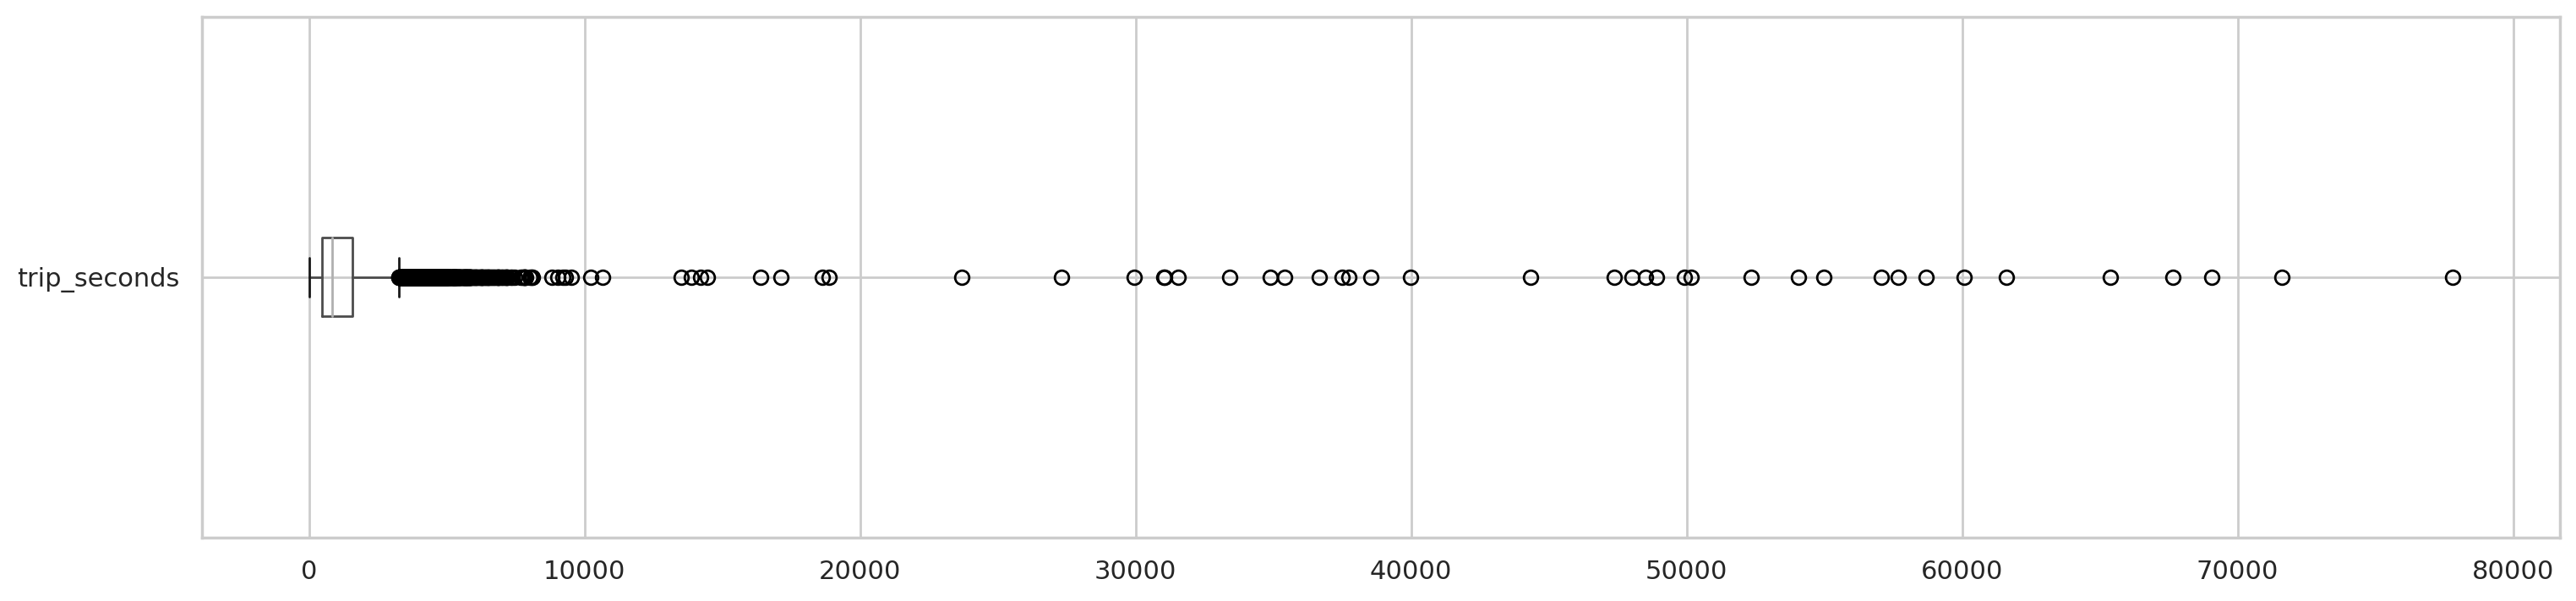

In [41]:
sampled_df.select('trip_seconds').toPandas().boxplot(column='trip_seconds', vert=False)

Видно много выбросов в данных, для улучшения качества моделей выбросы лучше убрать.

In [42]:
def filter_outliers(dataframe, columns, factor=1.5):
    """
    Detects and treats outliers using IQR for multiple variables in a PySpark DataFrame.

    :param dataframe: The input PySpark DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param factor: The IQR factor to use for detecting outliers (default is 1.5)
    :return: The processed DataFrame with outliers treated
    """
    for column in columns:
        quantiles = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        dataframe = dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    return dataframe

In [43]:
sampled_df = filter_outliers(sampled_df, columns_to_filter, factor=3)
sampled_df = filter_outliers(sampled_df, ['trip_seconds'], factor=3)

<Axes: >

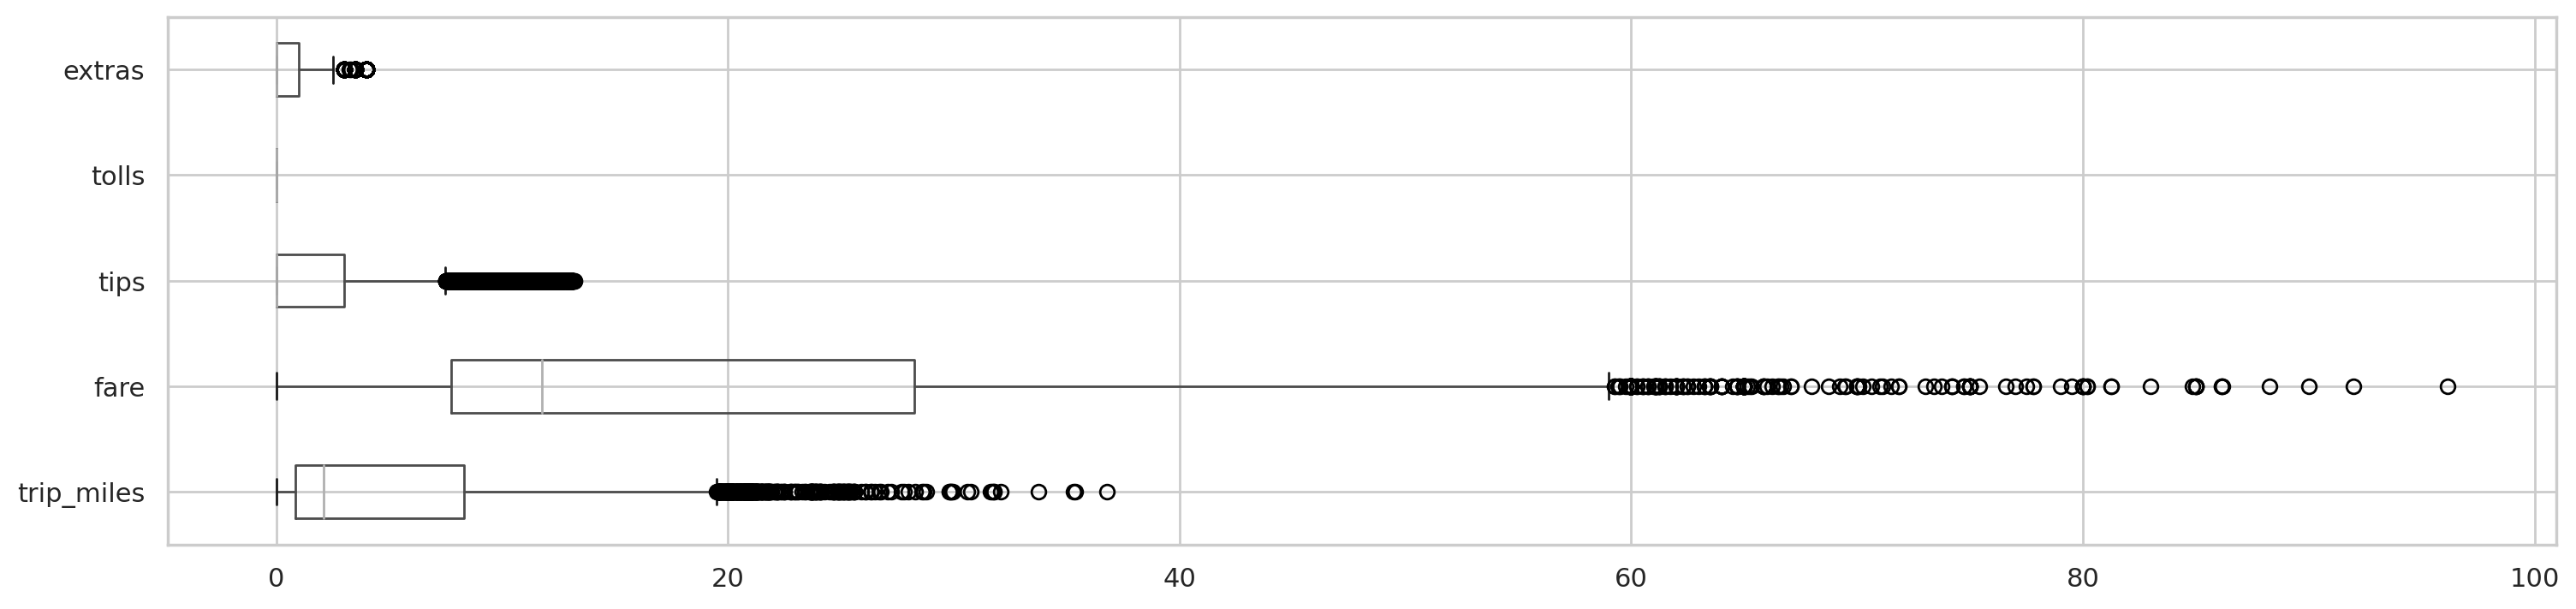

In [44]:
sampled_df.select(*columns_to_filter).toPandas().boxplot(column=columns_to_filter, vert=False)

<Axes: >

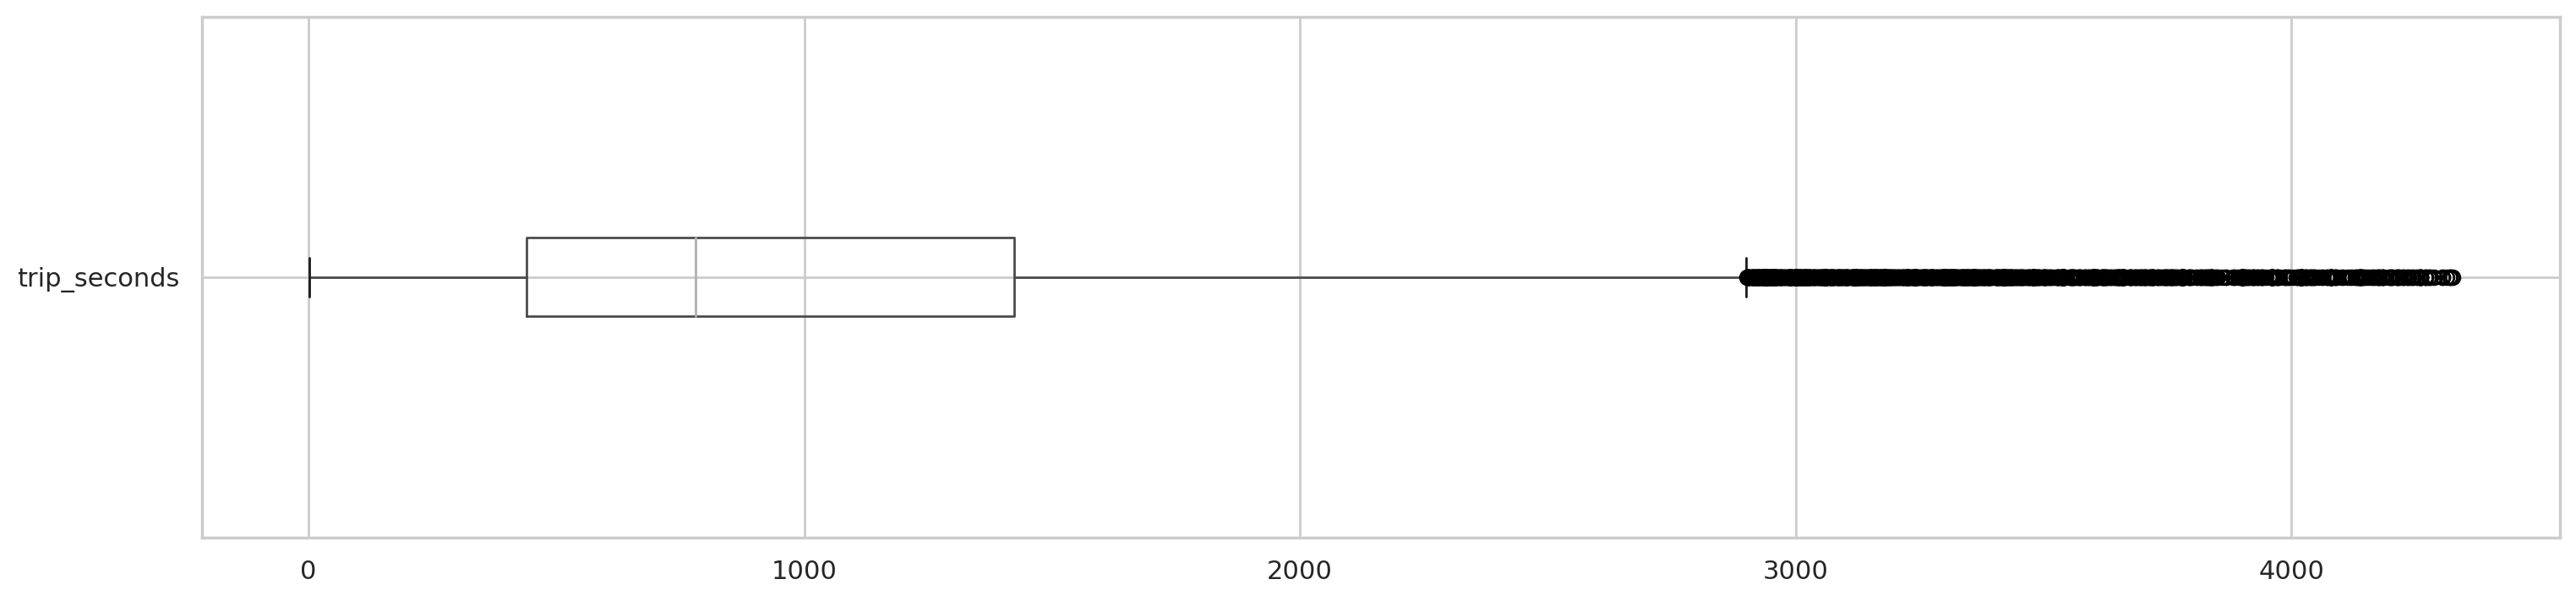

In [45]:
sampled_df.select('trip_seconds').toPandas().boxplot(column='trip_seconds', vert=False)

In [46]:
sampled_df.count()

38797

### Статистики и распределения

Избавились от аномальных поездок. Посмотрим на некоторые распределения.

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<Axes: xlabel='pickup_centroid_longitude', ylabel='pickup_centroid_latitude'>

(-87.93256378173828, -87.5159683227539, 41.642662811279294, 42.02709884643555)

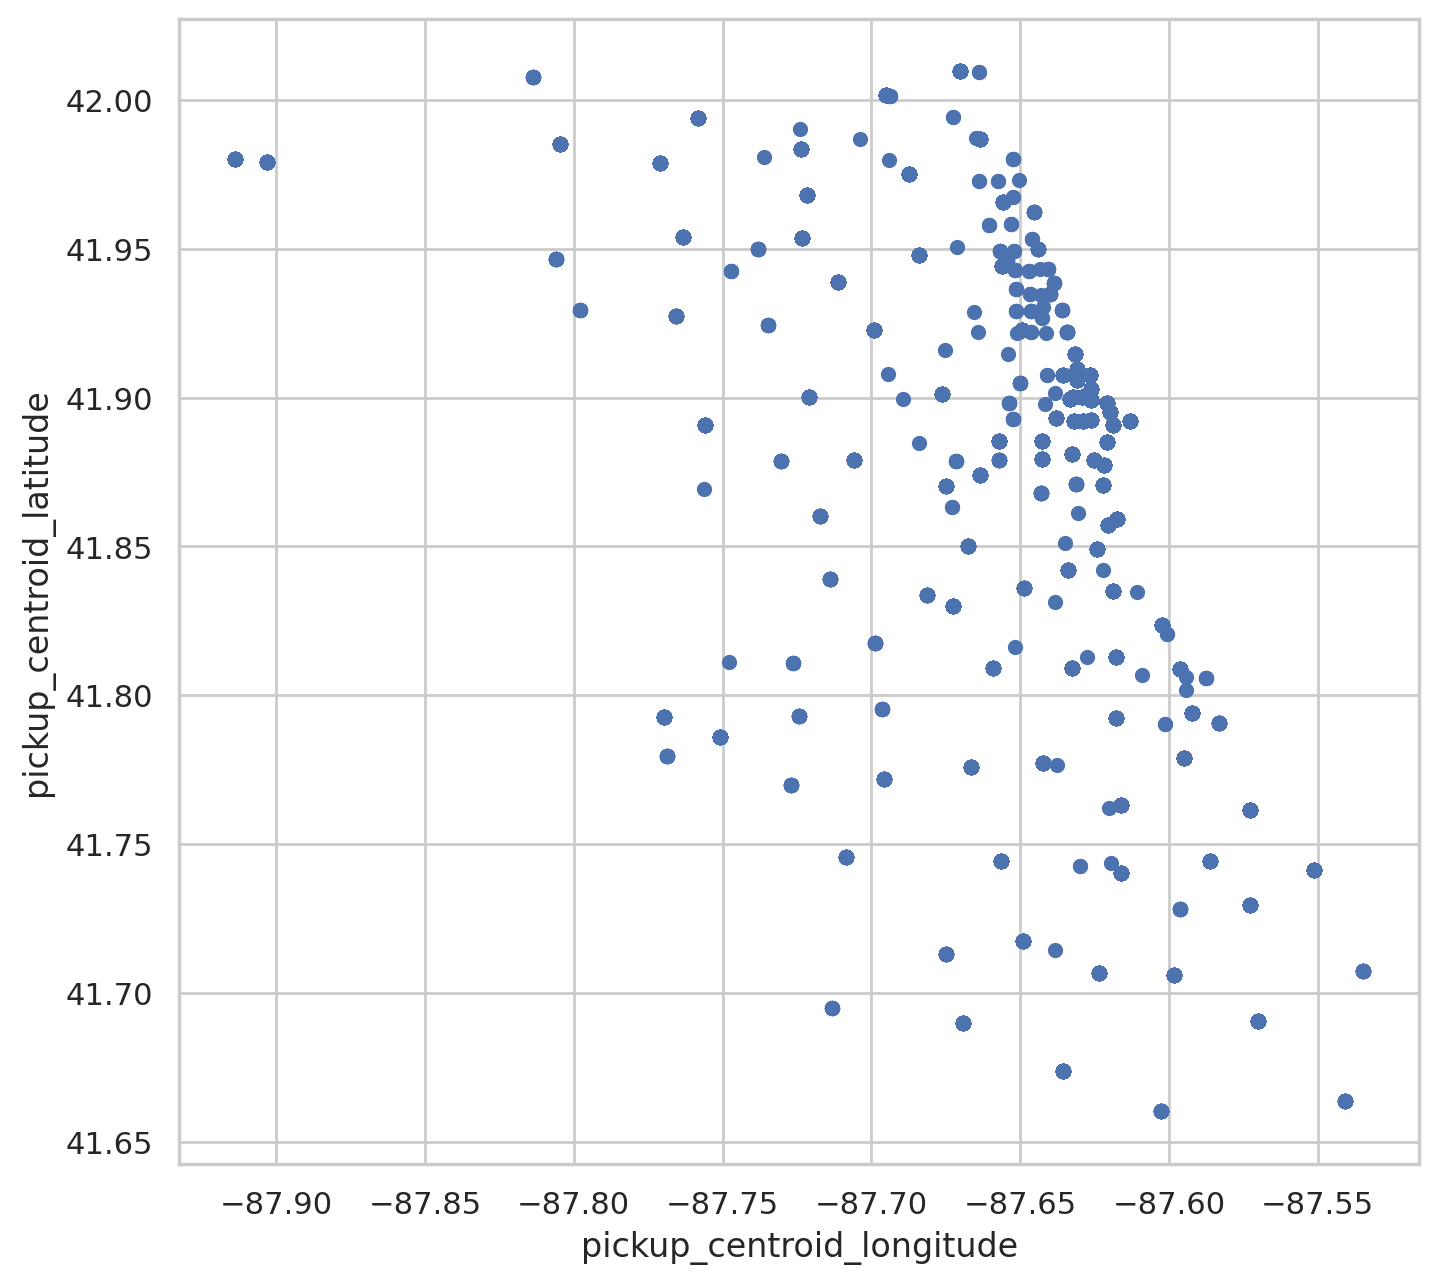

In [47]:
sampled_df.toPandas().plot.scatter(
    x='pickup_centroid_longitude',
    y='pickup_centroid_latitude',
    figsize=(8, 8)
)
plt.axis('scaled')
plt.show()

Явно видны контуры карты Чикаго.

Проверим с какой частотой вызывают такси в разный районах.

<Axes: xlabel='pickup_community_area'>

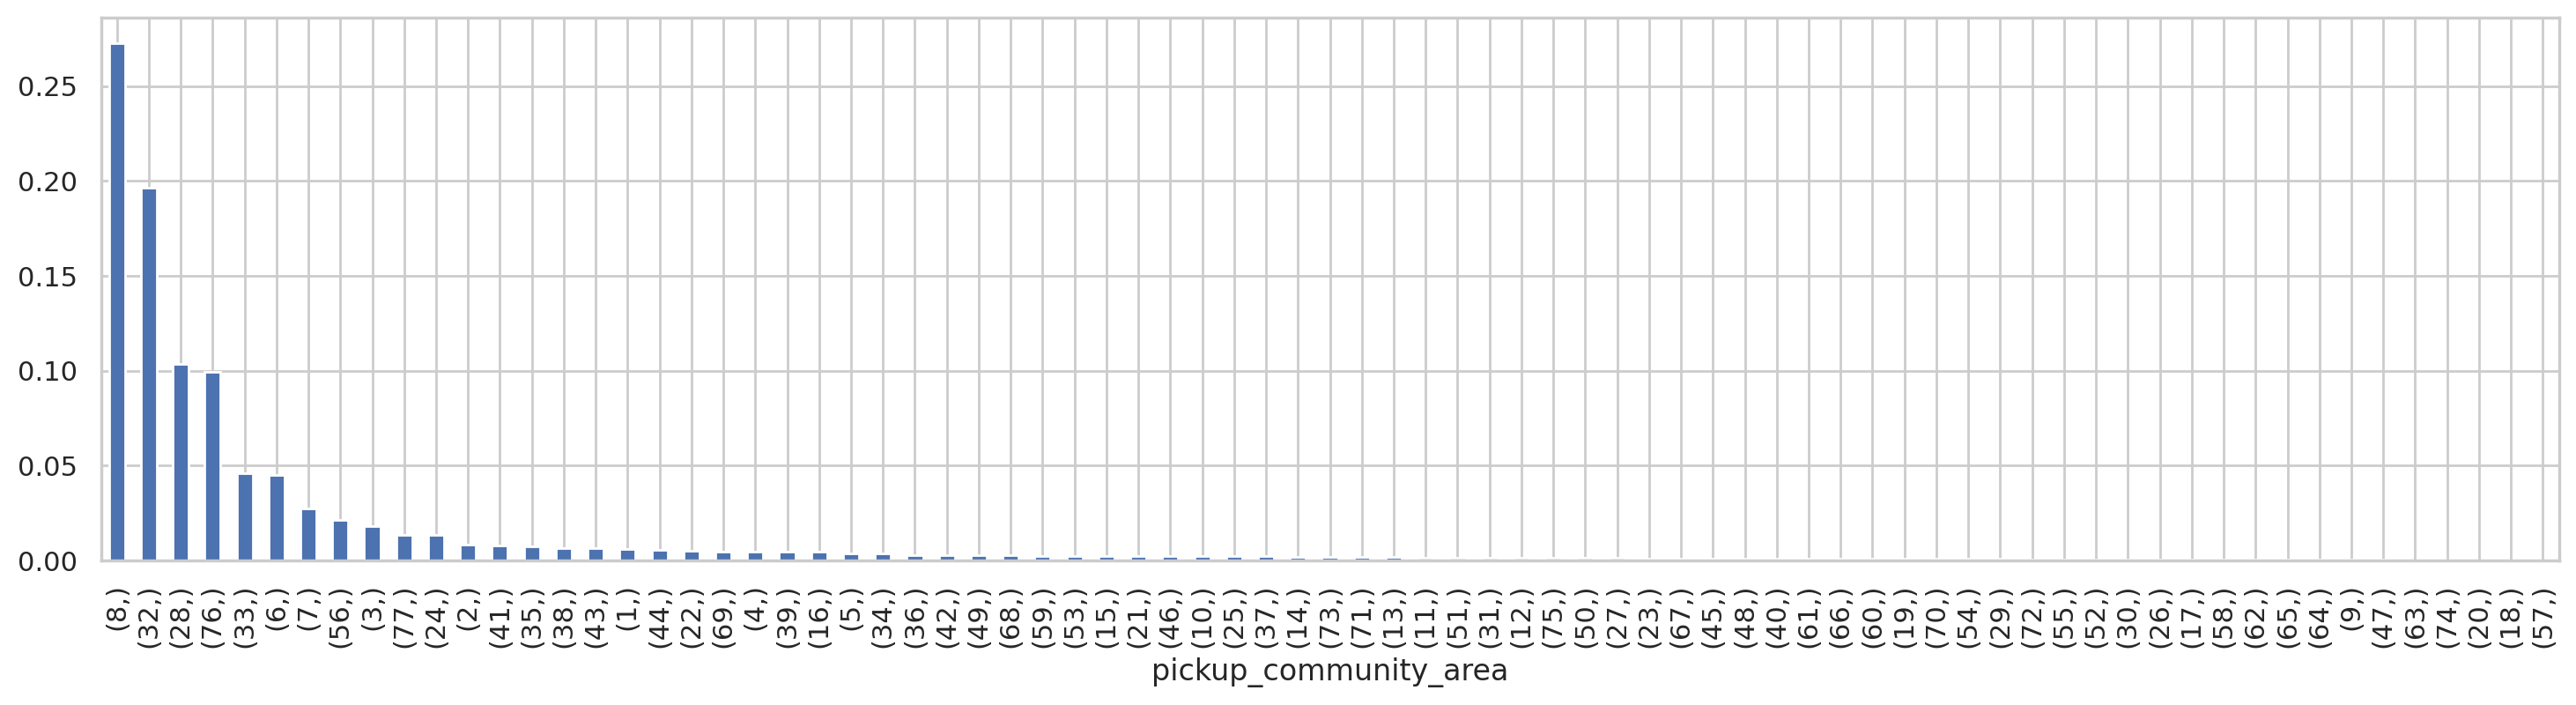

In [48]:
sampled_df.select('pickup_community_area').toPandas().value_counts(normalize=True).plot(kind='bar')

Видно сильно неравномерное распределение стартов заказов по районам, большая часть заказов приходится на центральные районы. Посмотрим по зонам высадки.

<Axes: xlabel='dropoff_community_area'>

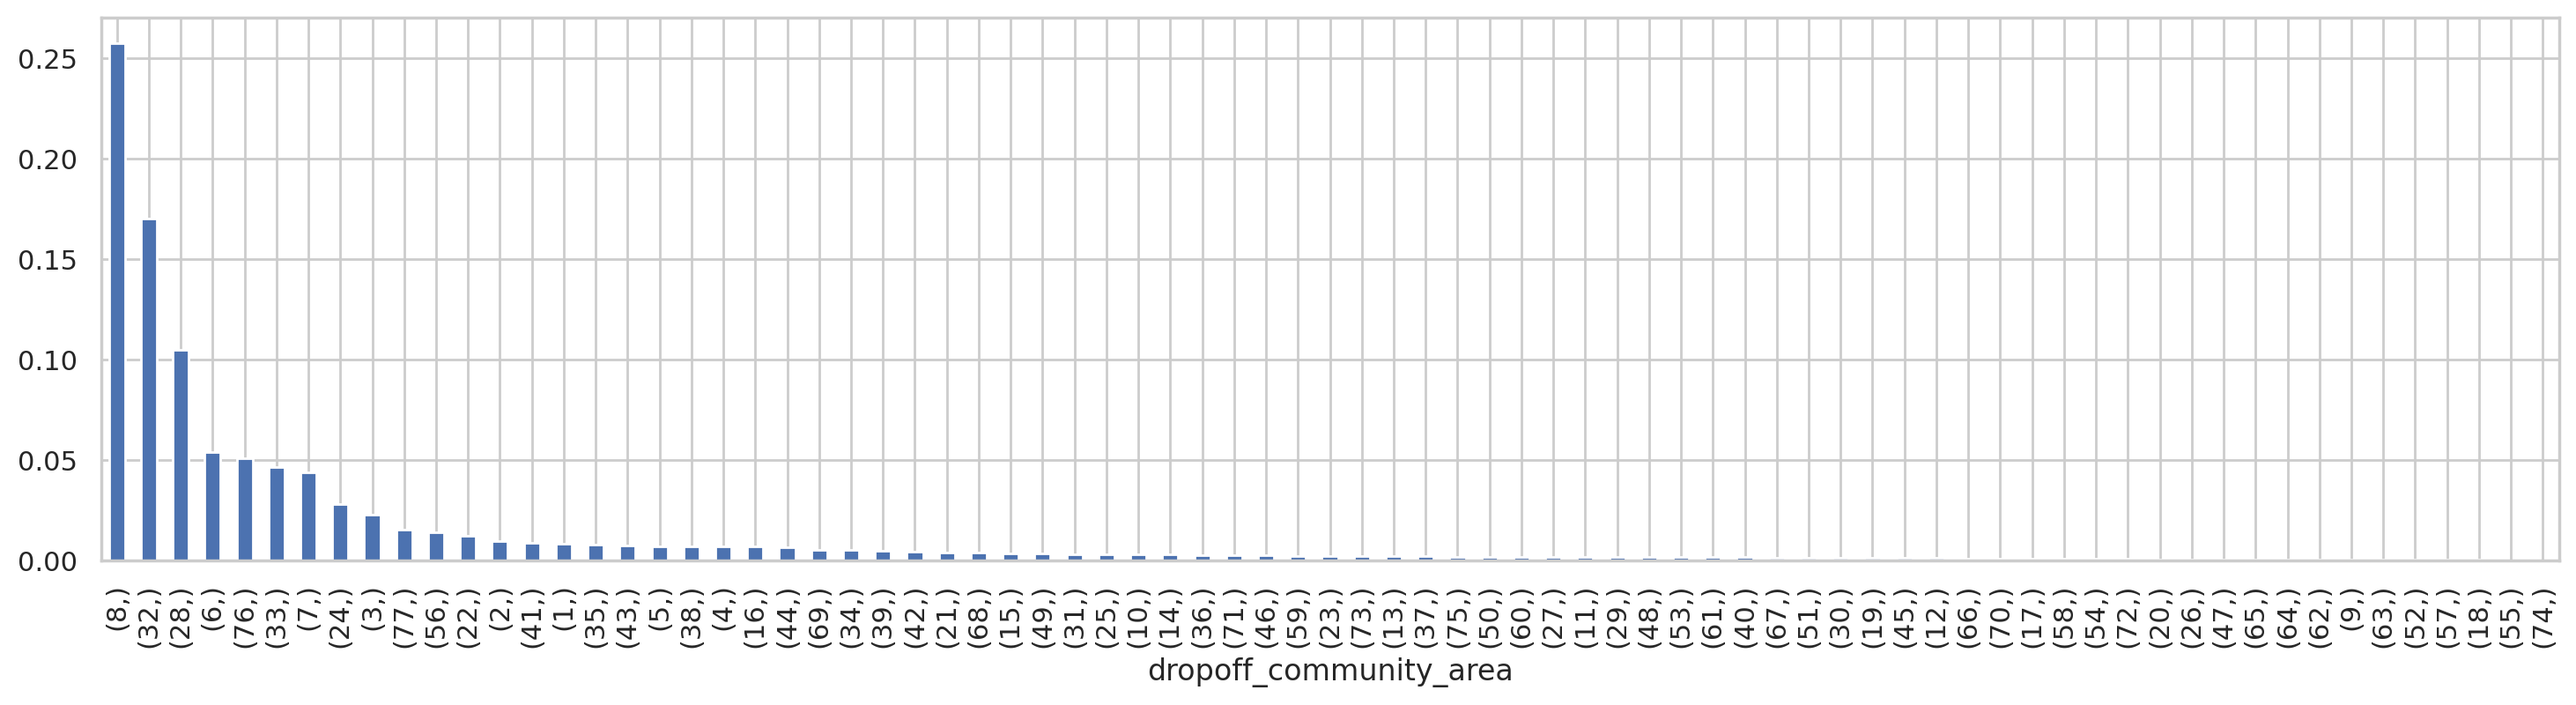

In [49]:
sampled_df.select('dropoff_community_area').toPandas().value_counts(normalize=True).plot(kind='bar')

Картина почти не меняется. Можно ожидать невысокую точность работы моделей в непопулярных районах.

Посмотрим на распределение типов оплаты и компаний такси.

In [50]:
def plot_cat_pie(df, column, threshold=0.05, max_slices=10):
    """
    Plot pie chart for passed DF and column, filtering slices by threshold and maximum number of slices.

    :param df: Input PySpark DataFrame
    :param column: Column name to drow pie on
    :param threshold: Minimum slice of the pie to be drow separatedly
    :param max_slices: Maximum number of pie slices to be drow separatedly
    :return: None
    """
    column_summary = df.select(column).toPandas().value_counts(normalize=True)
    column_summary = column_summary[:max_slices]
    column_summary = column_summary[column_summary > threshold]
    column_summary['Other'] = 1 - sum(column_summary)
    column_summary.plot.pie(autopct='%1.1f%%')
    return None

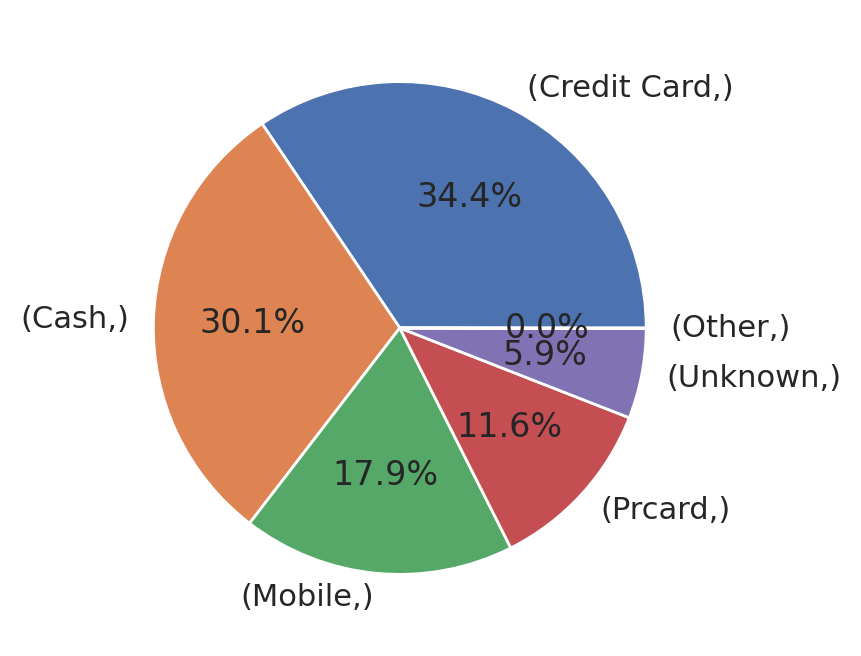

In [51]:
plot_cat_pie(sampled_df, 'payment_type')

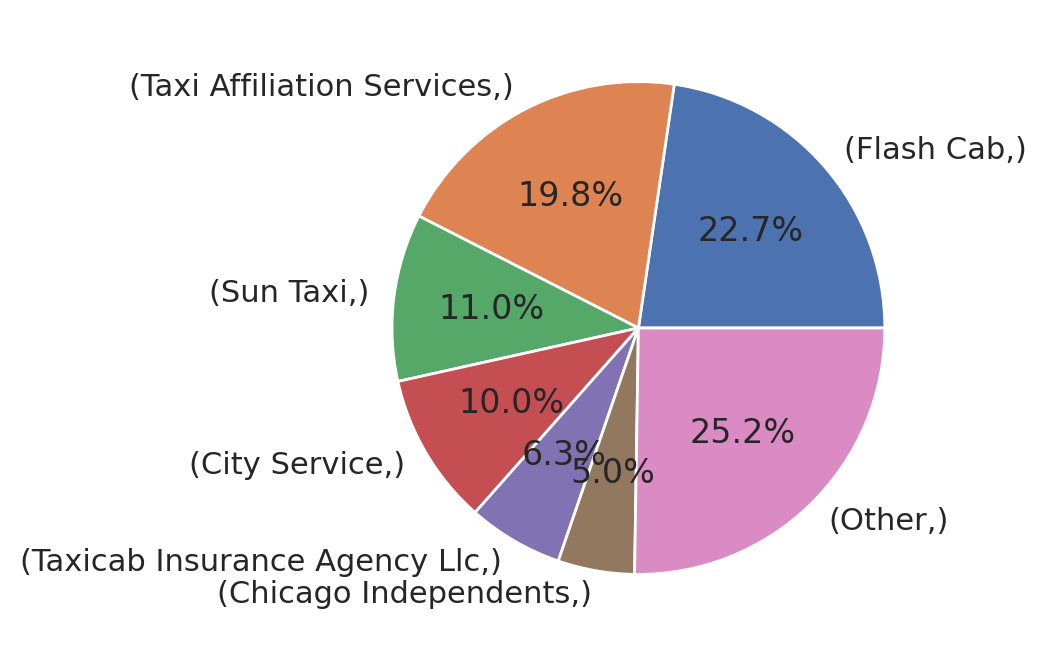

In [52]:
plot_cat_pie(sampled_df, 'company')

Среди средств оплаты наиболее распространены кредитные карты, наличные и оплата через приложение. Компаний перевозчиков представлено много, но почти 75% всех перевозок приходится на 6 перевозчиков.

Чтобы проанализировать количества заказов во времени - агрегируем наши данные в почасовую выборку.

In [53]:
agg_sampled_df = sampled_df.groupBy(F.date_trunc('hour', 'trip_start_timestamp').alias('hour')) \
                   .agg(F.avg('trip_seconds').alias('avg_trip_seconds'),
                        F.avg('trip_miles').alias('avg_trip_miles'),
                        F.avg('fare').alias('avg_fare'),
                        F.avg('tips').alias('avg_tips'),
                        F.avg('tolls').alias('avg_tolls'),
                        F.avg('extras').alias('avg_extras'),
                        F.count('*').alias('orders')
                       ).sort('hour', ascending=True).toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [54]:
agg_sampled_df.set_index('hour', inplace=True)
agg_sampled_df = agg_sampled_df.asfreq(freq='H', method='pad')

Проверим, отсортировалась ли наша выборка верно.

In [55]:
agg_sampled_df.index.is_monotonic_increasing

True

Посмотрим на распределение заказов по времени. Разделим на тренд и сезонные явления.

<Figure size 1300x500 with 0 Axes>

<Axes: >

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Trend')

<Axes: >

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

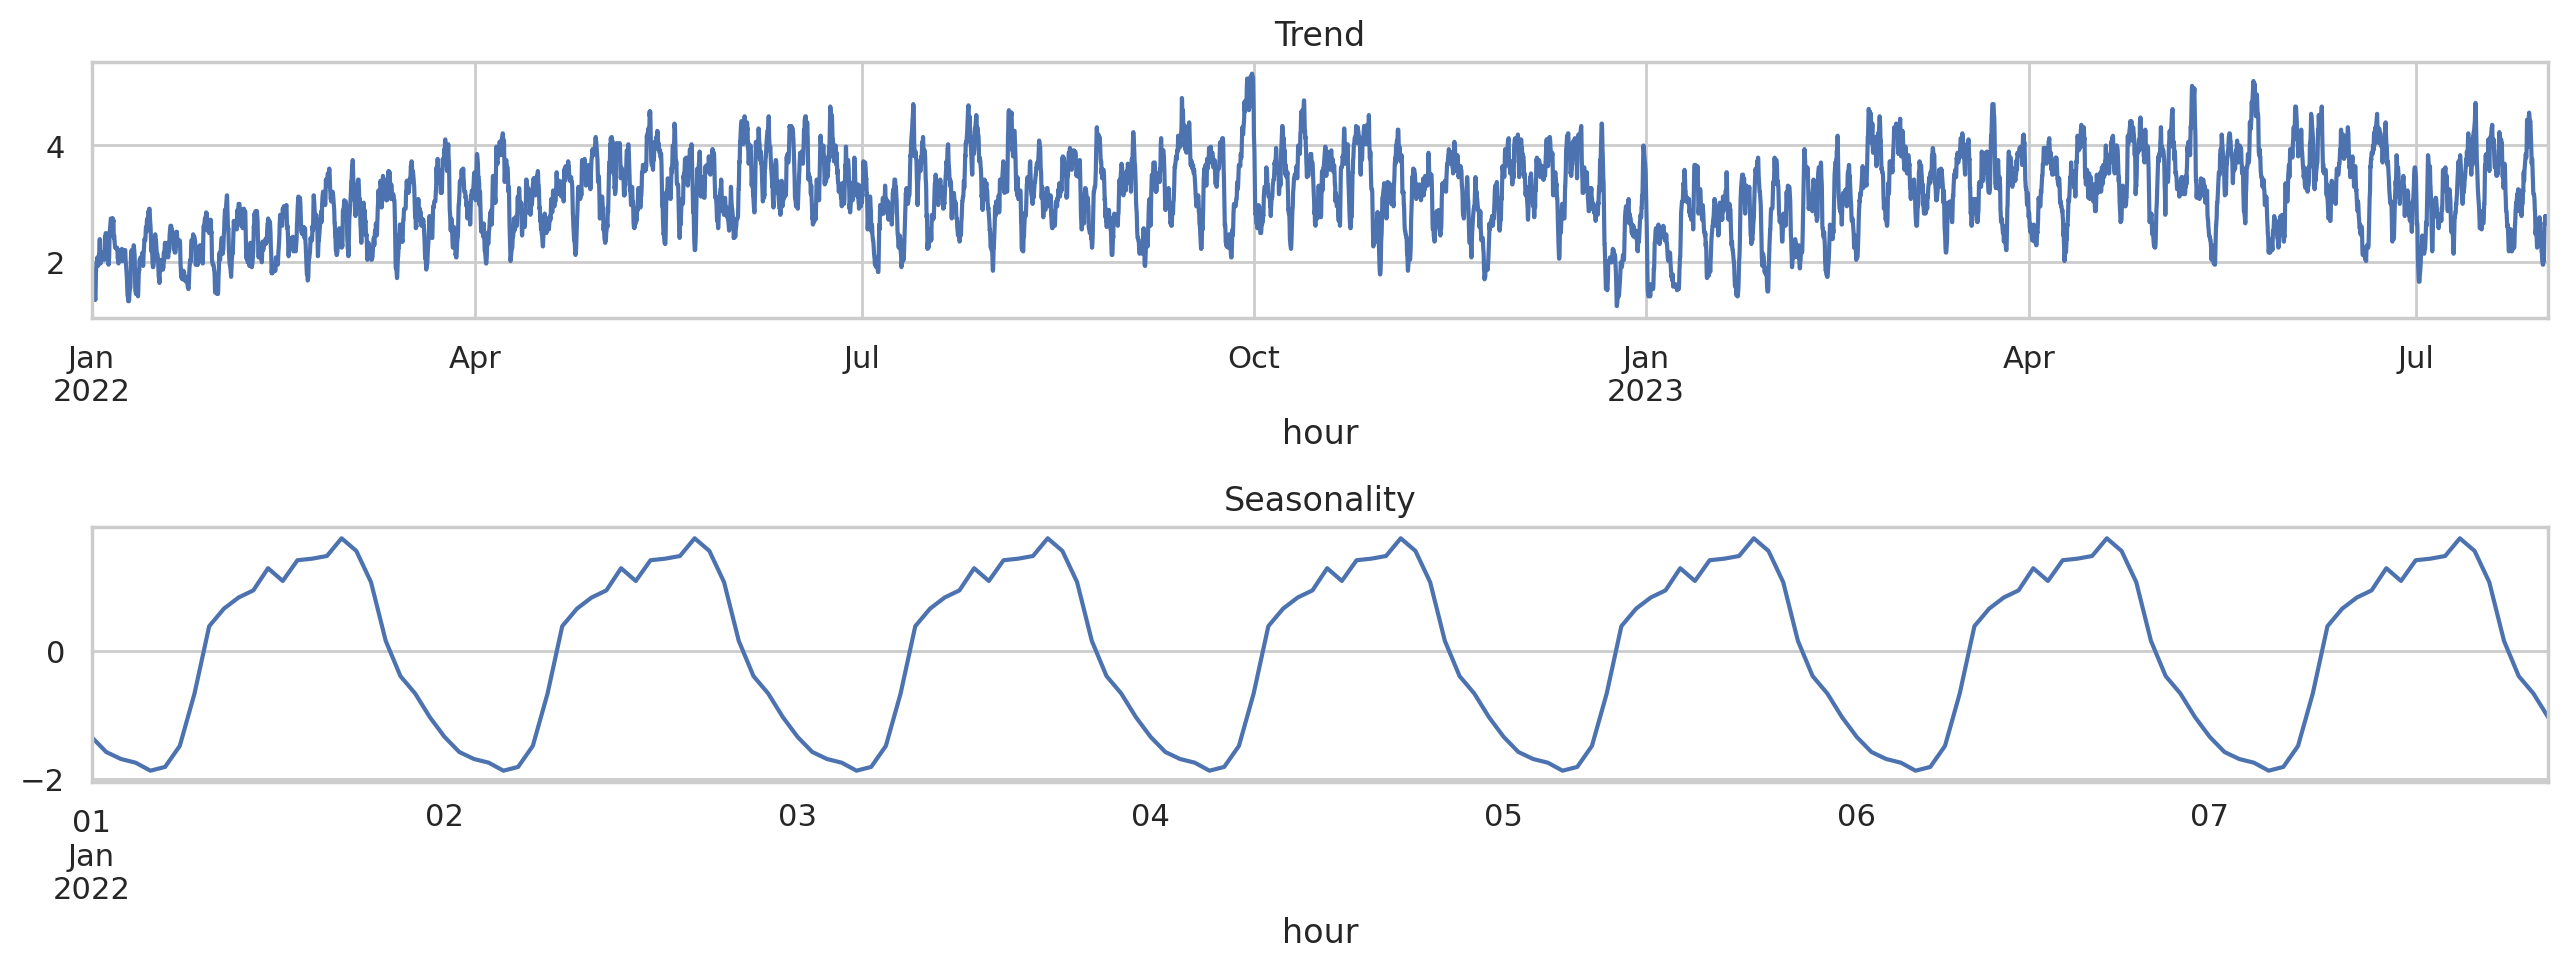

In [56]:
decomposed = seasonal_decompose(agg_sampled_df.orders)
plt.figure(figsize=(13, 5))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

На тренде мы видим изменения в течении года. Зимой общее количество заказов меньше, постепенно возрастает к апрелю и держится на высоком уровне до октября и начинает снижаться к минимуму в январе.
Если рассмотреть сезонные явления в течении недели - явно заметно увеличение количества заказов днём, особенно к вечеру и уменьшение их ранним утром.
Посмотрим внимательно на данные за пару месяцев.

<Figure size 1600x250 with 0 Axes>

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Trend')

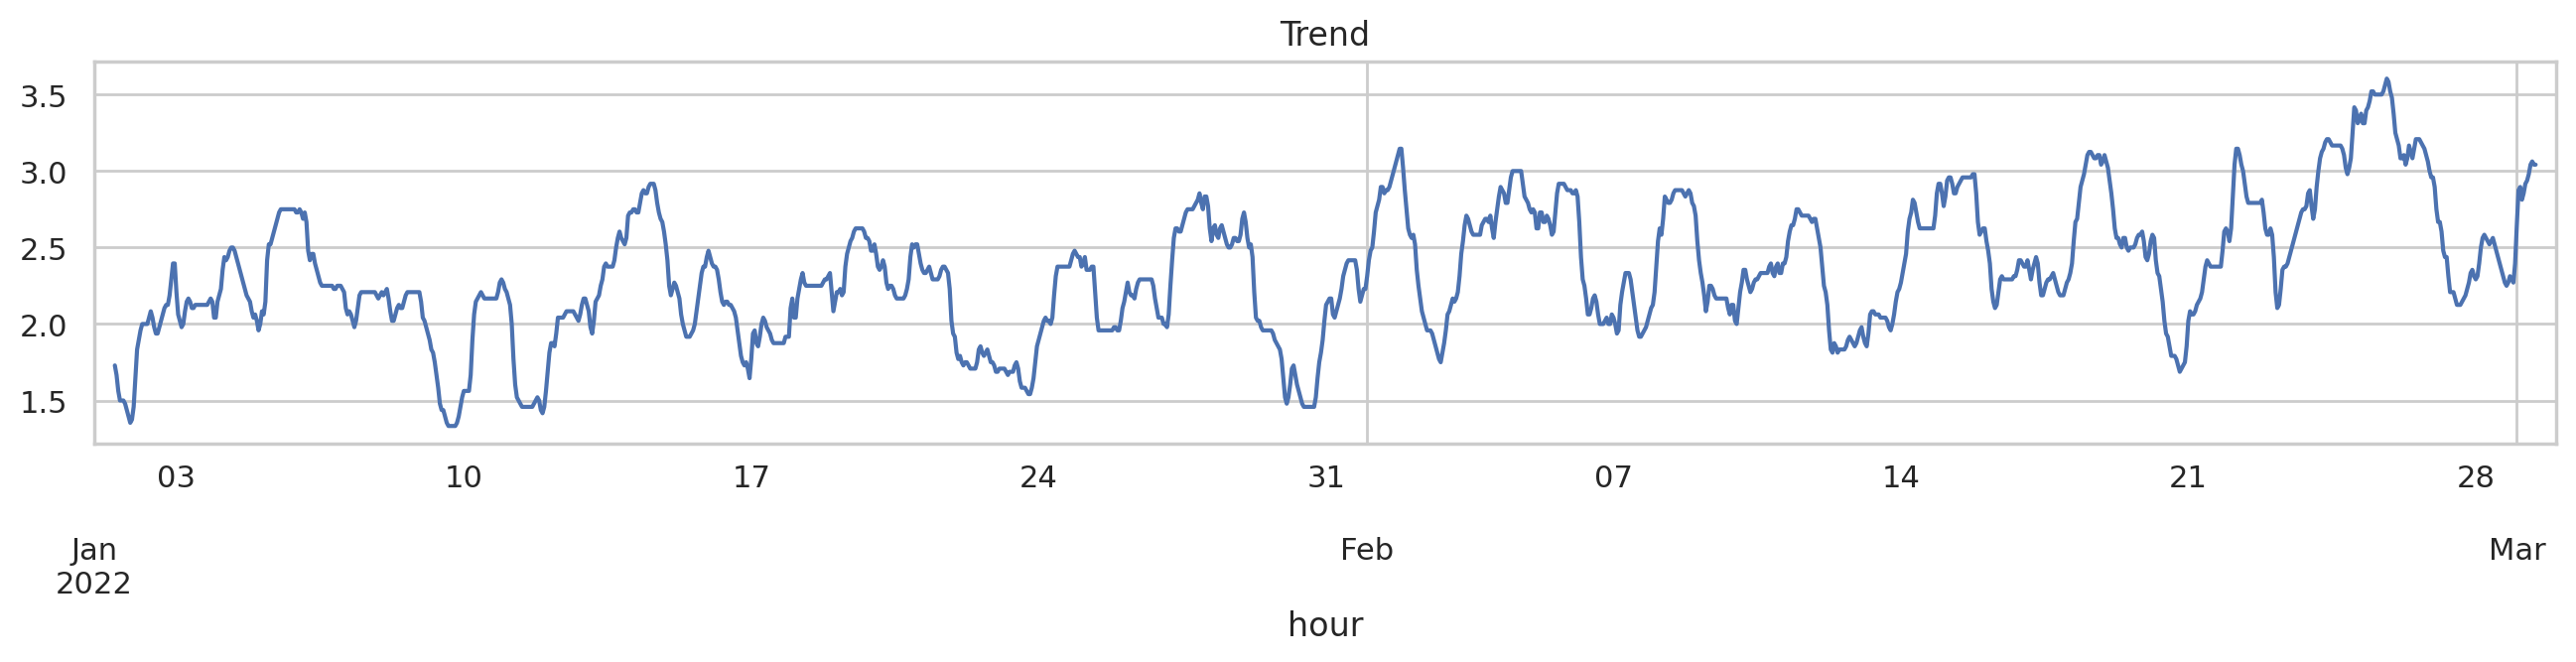

In [57]:
decomposed = seasonal_decompose(agg_sampled_df.orders.loc['2022-01-01':'2022-03-01'])
plt.figure(figsize=(16, 2.5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Здесь видны недельные циклы. 03.01.2022 это понедельник. Видны падения заказов такси по выходным, увеличением в будние дни. Наблюдаются пики заказов по понедельникам-вторникам и пятницам. Всё это ценная информация для моделей.

Попробуем проанализировать другие показатели. Начнём со среднего времени поездки.

<Figure size 1300x500 with 0 Axes>

<Axes: >

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Trend')

<Axes: >

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

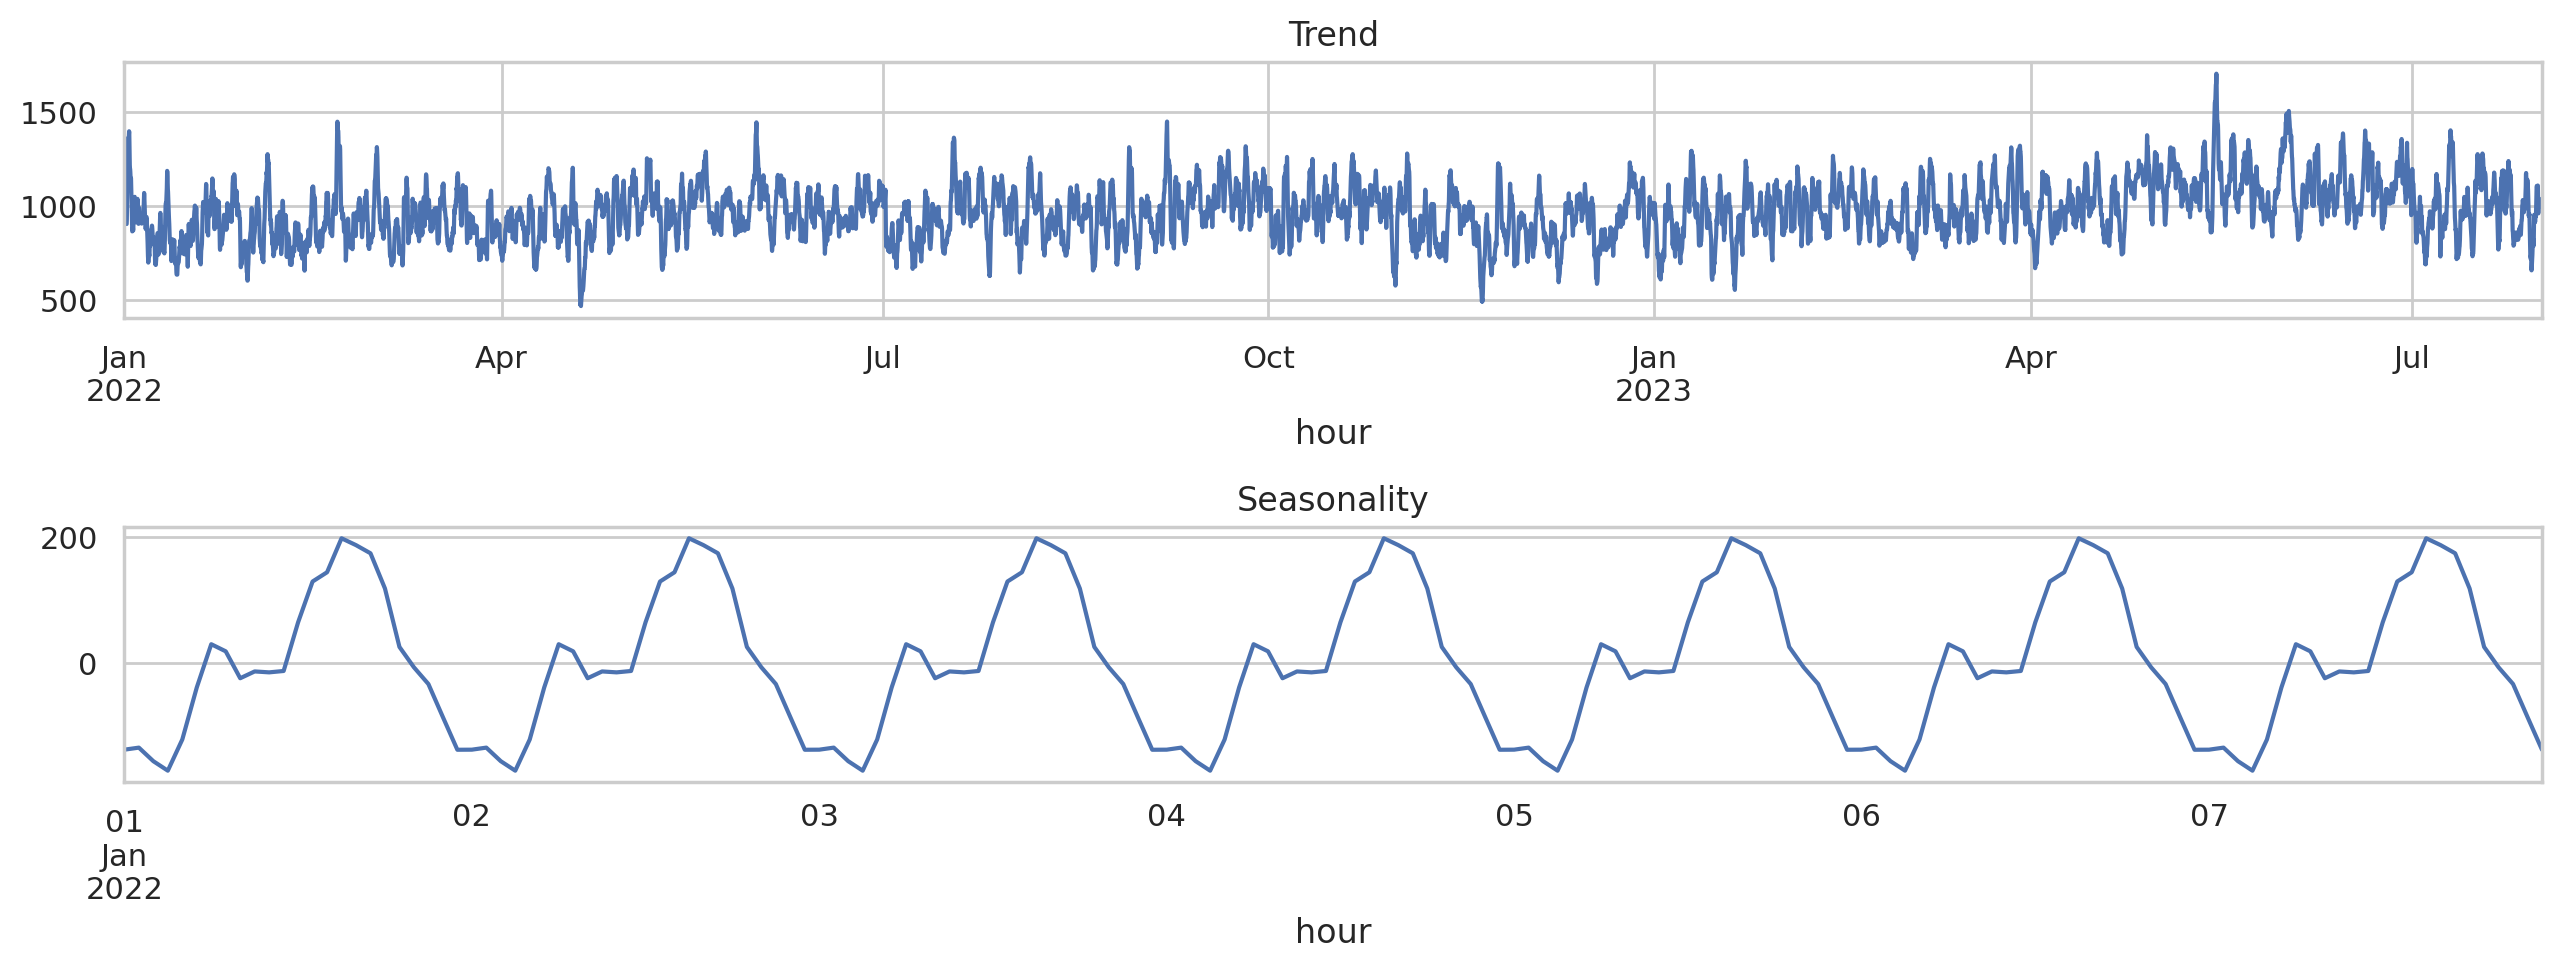

In [58]:
decomposed = seasonal_decompose(agg_sampled_df.avg_trip_seconds)
plt.figure(figsize=(13, 5))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

В среднем времени поездки сложно разглядеть какой-либо тренд, но сезонные явления выражены в увеличении времени в утренний час пик и, особенно, в вечерний. Вероятно, стоит оставить этот признак.

Посмотрим на среднюю дистанцию поездки.

<Figure size 1300x500 with 0 Axes>

<Axes: >

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Trend')

<Axes: >

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

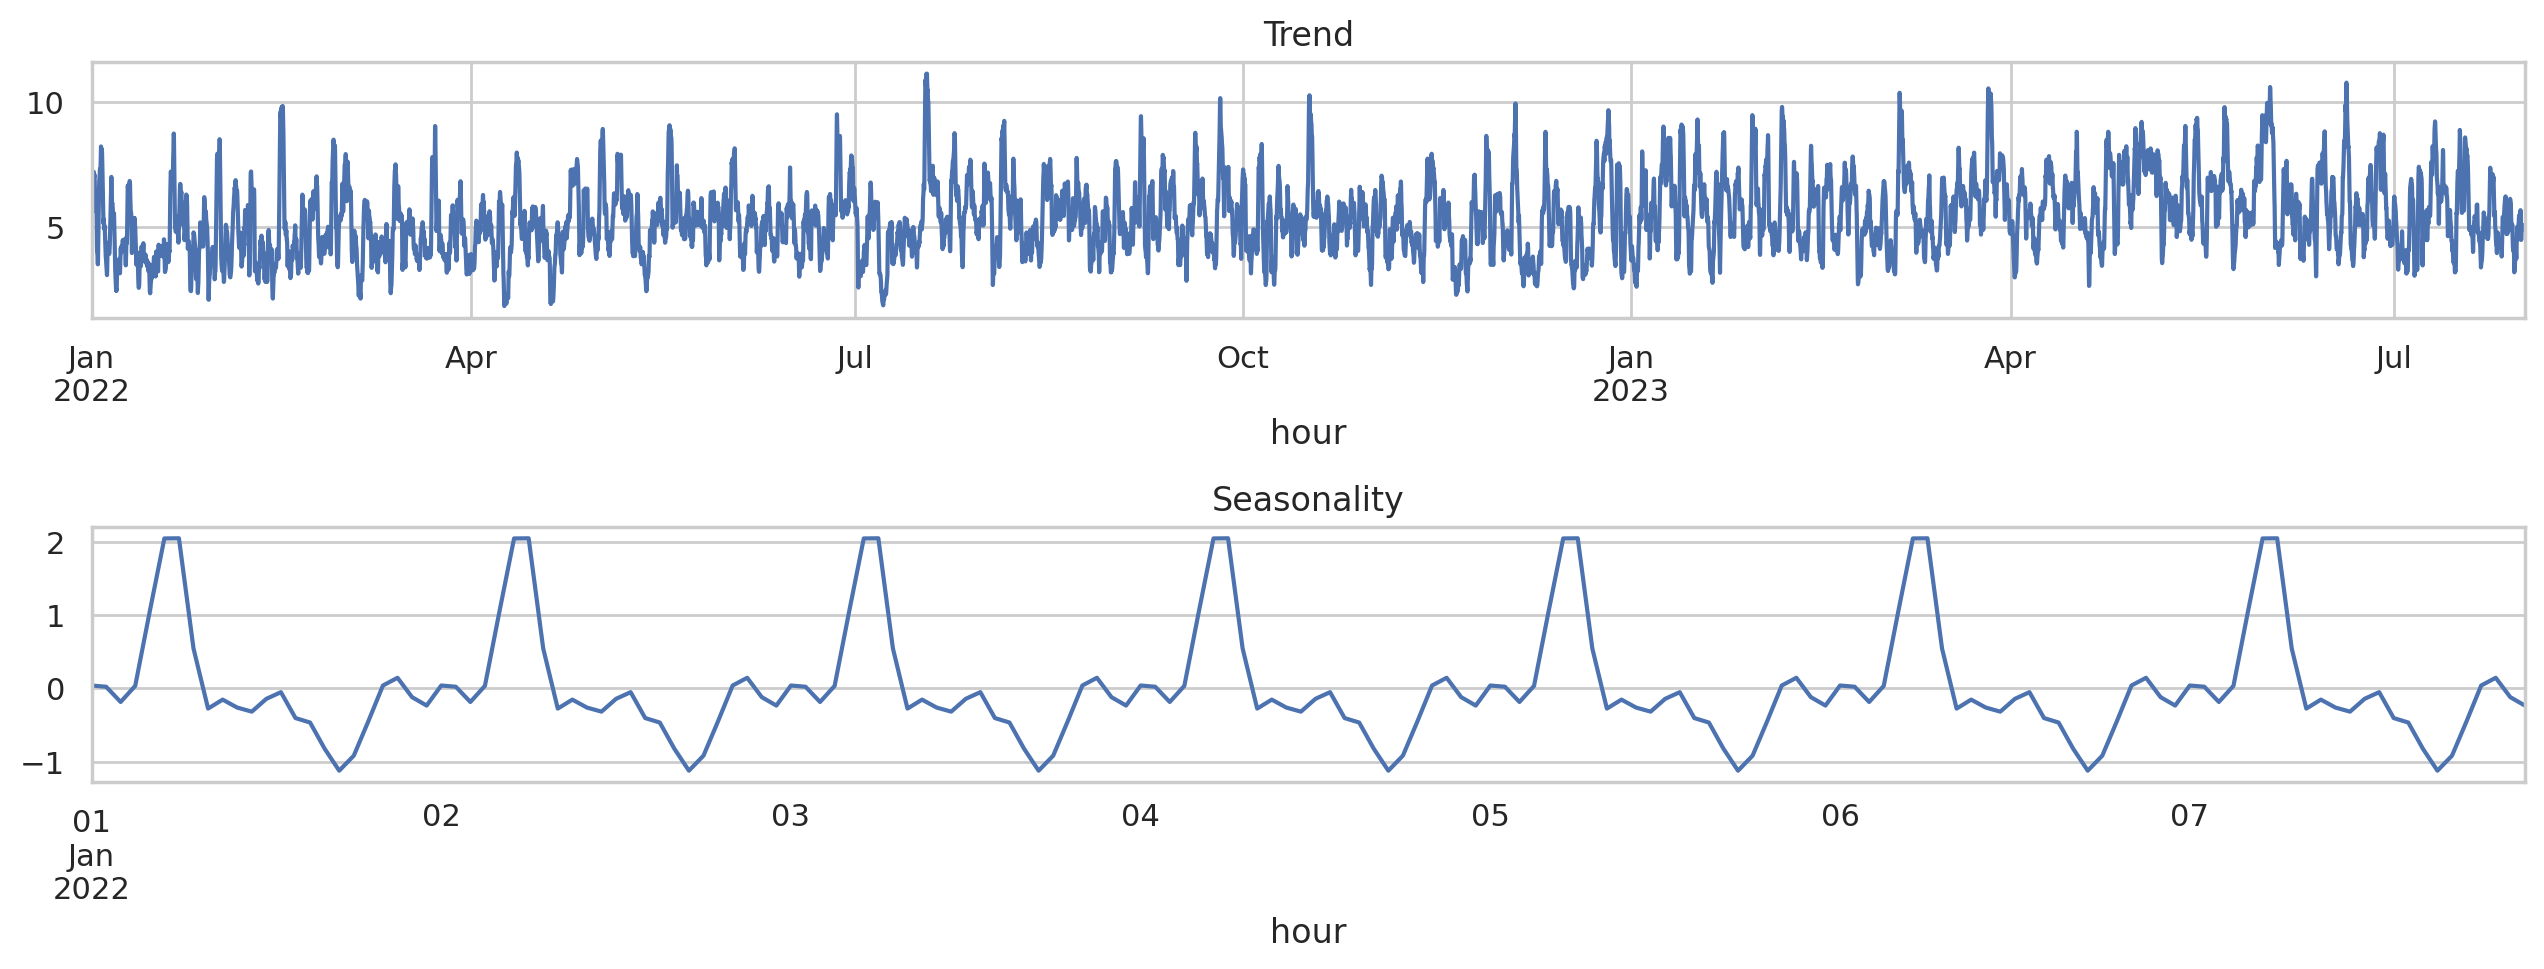

In [59]:
decomposed = seasonal_decompose(agg_sampled_df.avg_trip_miles)
plt.figure(figsize=(13, 5))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

В трендах сложно разглядеть какое-то направление, а вот в сезонных явлениях видны внутрисуточные колебания. Пик увеличения дистанции ранним утром (вероятно, развоз из спальных районов в офисные), а также сокращение средней дистанции в вечерний час пик (возможно по окончанию дня работники разъезжаются по своим делам в городе на небольшие дистанции). Признак стоит оставить.

Посмотрим на данные по оплате.

<Figure size 1600x200 with 0 Axes>

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

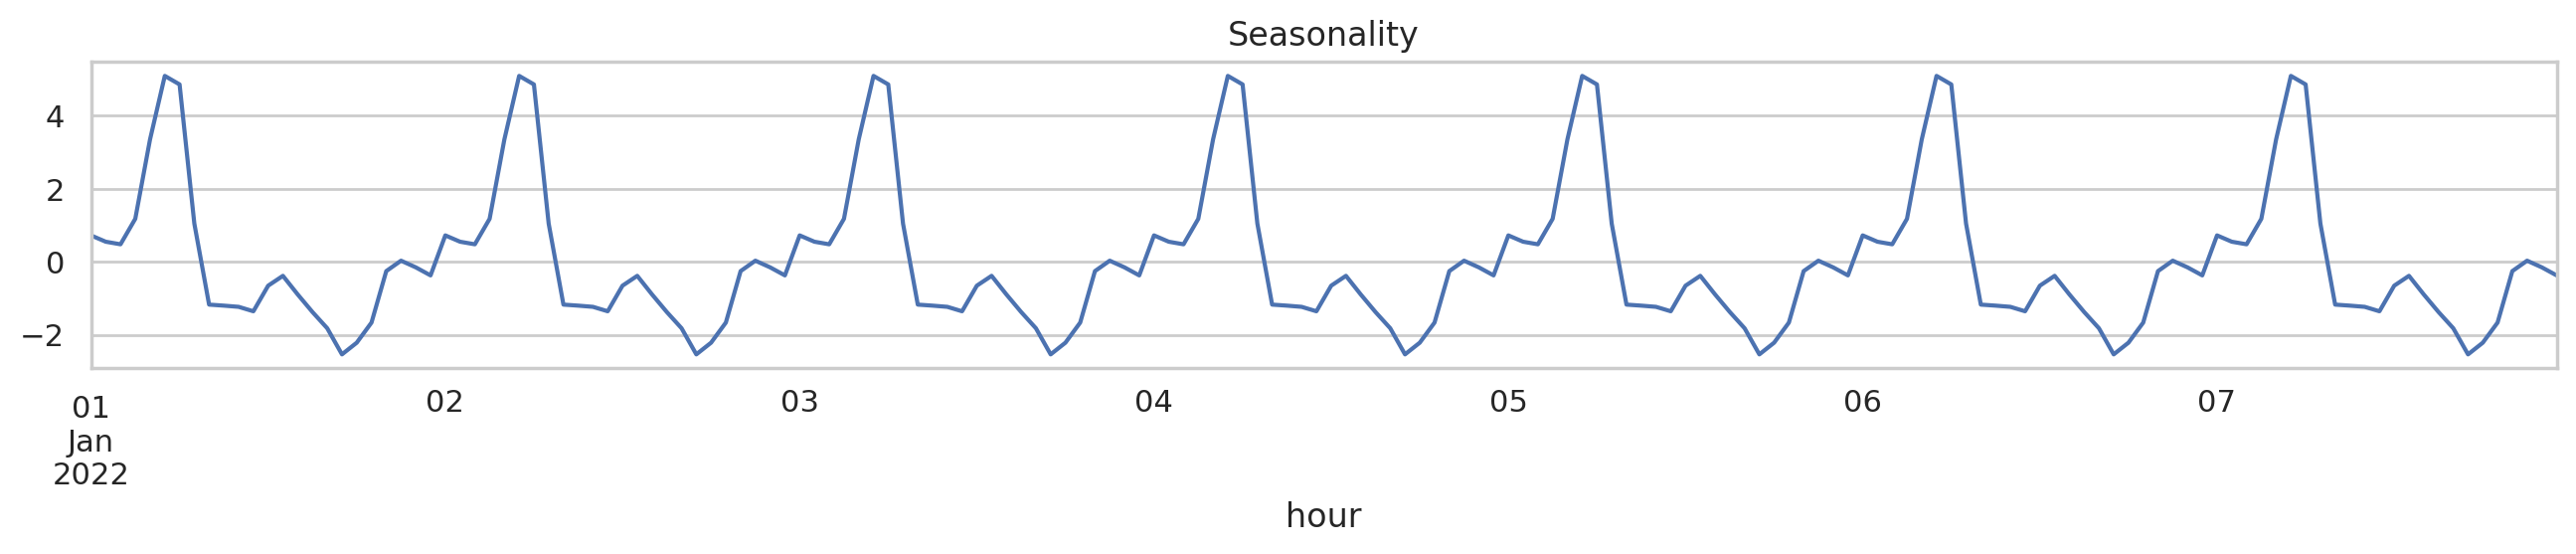

In [60]:
decomposed = seasonal_decompose(agg_sampled_df.avg_fare)
plt.figure(figsize=(16, 2))
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')

На базовой величине оплаты видны те же пики что и на средней дистанции поездки, что логично. Увеличение в утренний час-пик и падение в вечерний.

Посмотрим на чаевые.

<Figure size 1600x200 with 0 Axes>

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

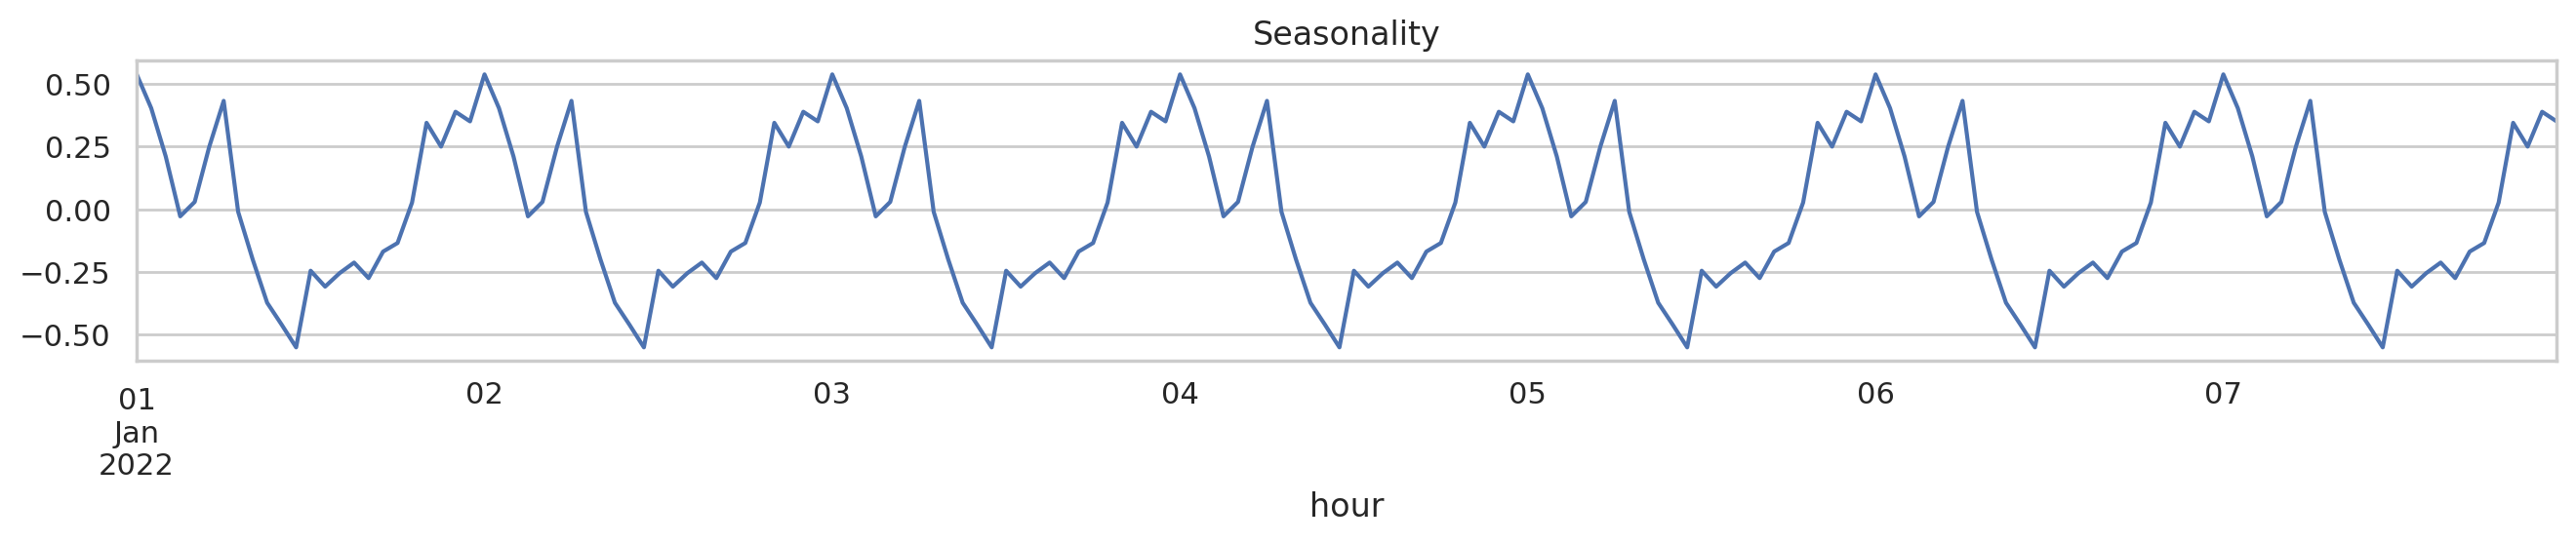

In [61]:
decomposed = seasonal_decompose(agg_sampled_df.avg_tips)
plt.figure(figsize=(16, 2))
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')

<Figure size 1600x200 with 0 Axes>

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

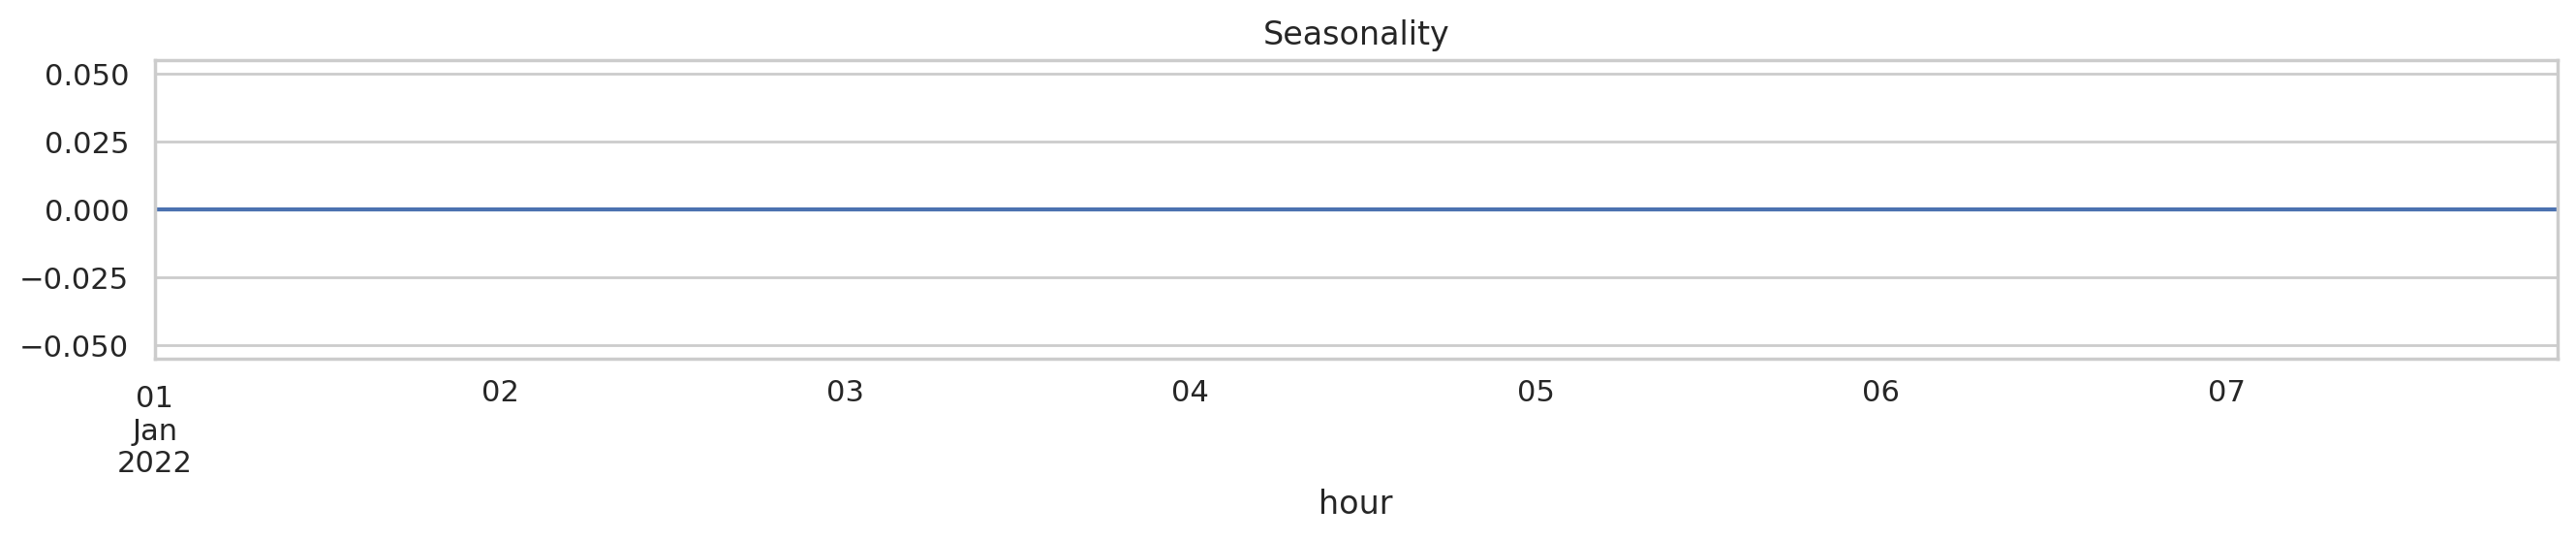

In [62]:
decomposed = seasonal_decompose(agg_sampled_df.avg_tolls)
plt.figure(figsize=(16, 2))
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')

<Figure size 1600x200 with 0 Axes>

<Axes: xlabel='hour'>

Text(0.5, 1.0, 'Seasonality')

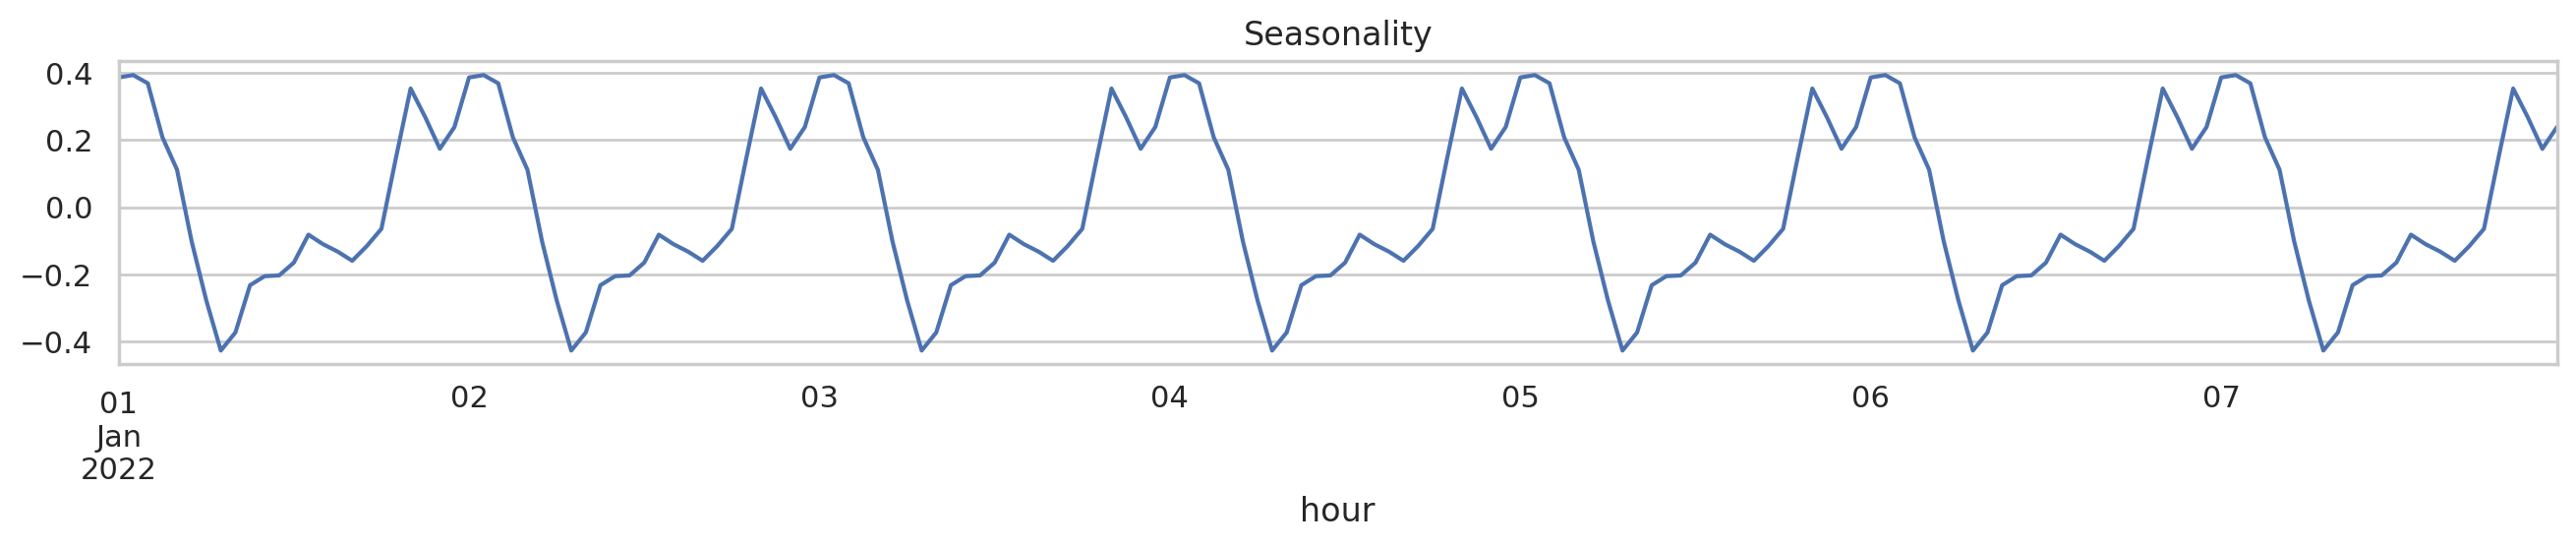

In [63]:
decomposed = seasonal_decompose(agg_sampled_df.avg_extras)
plt.figure(figsize=(16, 2))
decomposed.seasonal.loc['2022-01-01':'2022-01-07'].plot(ax=plt.gca())
plt.title('Seasonality')

Чаевые чаще оставляют в ночное время и реже днём.

Средние затраты на проезд по платным дорогам не имеют выраженной сезонности.

Дополнительные услуги также как и чаевые чаще оплачивают ночью и реже утром-днём.

Таким образом часть из этих признаков имеет внутридневные колебания и может помочь в предсказании количества заказов на следующий час.

В связи с сильно ограниченным количеством памяти на локальной машине, пересоздадим spark сессию перед работой с моделями машинного обучения.

In [64]:
spark.catalog.clearCache()
spark.stop()
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config("spark.task.cpus", 1) \
    .getOrCreate()
df = spark.read.csv(path=[TAXI_DATA_22, TAXI_DATA_23], schema=schema, header=True)

## Обучение моделей

### Linear Regression

Используем модель линейной регрессии для построения baseline на основе почасового количества заказов по каждому региону.

Для начала разделим данные на обучающую валидационную и тестовые выборки и проведём предварительную обработку данных.

In [65]:
df = df.select('trip_start_timestamp', 'trip_seconds', 'trip_miles', 'pickup_community_area', 'fare', 'tips', 'extras')
df = df.withColumn('trip_start_timestamp', F.to_timestamp(col('trip_start_timestamp'),'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn('rank', F.percent_rank().over(Window.orderBy('trip_start_timestamp')))
df = df.dropna()
df = df.filter(~((col('trip_seconds') == 0) & (col('trip_miles') != 0)))
df = df.filter(~((col('trip_seconds') == 0) & (col('trip_miles') == 0)))

df_train = df.where('rank <= .6').drop('rank')
df_valid = df.where('rank > .6 AND rank <= .8').drop('rank')
df_test = df.where('rank > .8').drop('rank')

Уберём выбросы в данных.

In [66]:
%%time
for part in tqdm(['train', 'valid', 'test']):
    globals()[f'df_{part}'] = filter_outliers(globals()[f'df_{part}'], ['trip_seconds', 'trip_miles', 'fare', 'tips', 'extras'], factor=3)

100%|██████████| 3/3 [06:56<00:00, 138.88s/it]

CPU times: user 207 ms, sys: 80.7 ms, total: 287 ms
Wall time: 6min 56s


После очистки даных напишем функцию которая будет выдавать порегионные агрегированные по часу данные о поездках.

In [67]:
def get_region_data(data, region):
    """
    Take PySpark DataFrame and extract sub-DataFrame based on pickup_community_area and aggregated by 1 hour from trip_start_timestamp.
    """
    data = data.filter(col('pickup_community_area') == region) \
        .drop('pickup_community_area') \
        .groupBy(F.date_trunc('hour', 'trip_start_timestamp').alias('hour')) \
        .agg(F.count('*').alias('orders'),
             F.avg('trip_seconds').alias('avg_trip_seconds'),
             F.avg('trip_miles').alias('avg_trip_miles'),
             F.avg('fare').alias('avg_fare'),
             F.avg('tips').alias('avg_tips'),
             F.avg('extras').alias('avg_extras')).sort('hour', ascending=True)
    return data

Напишем функцию генерирующую новые признаки.

In [68]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Takes DataFrame and generates new features.
    """
    data = data.withColumn('month', F.month(col('hour')))
    data = data.withColumn('day', F.dayofmonth(col('hour')))
    data = data.withColumn('day_of_week', F.dayofweek(col('hour')))
    w = Window.orderBy('hour')
    for lag in range(1, max_lag + 1):
        data = data.withColumn('lag_{}'.format(lag), F.lag('orders', lag).over(w))
    data = data.withColumn('lag_week', F.lag('orders', 7 * 24).over(w))
    w = Window.orderBy('hour').rowsBetween(-1 - rolling_mean_size,-1)
    data = data.withColumn('rolling_mean_{}'.format(rolling_mean_size), F.avg('orders').over(w))
    data = data.dropna()
    return data

Создадим порегионные наборы данных.

In [69]:
%%time
for part in ['train', 'valid', 'test']:
    for region in tqdm(range(1, 78)):
        globals()[f'df_{part}_{region}'] = make_features(get_region_data(globals()[f'df_{part}'].sort('trip_start_timestamp'), region), 24, 24).cache()

100%|██████████| 77/77 [00:36<00:00,  2.11it/s]

CPU times: user 6.2 s, sys: 4.07 s, total: 10.3 s
Wall time: 1min 43s


Для линейной модели категориальные данные будем обрабатывать OHE, а числовые данные отшкалируем.

In [70]:
cat_cols = ['month', 'day' ,'day_of_week']
num_cols = ['lag_{}'.format(c + 1) for c in range(24)] + ['lag_week', 'rolling_mean_24'] + ['avg_trip_seconds', 'avg_trip_miles', 'avg_fare', 'avg_tips', 'avg_extras']

Объявим estimator'ы.

In [71]:
encoder = OneHotEncoder(inputCols=cat_cols, outputCols=[c + '_ohe' for c in cat_cols])
numerical_assembler = VectorAssembler(inputCols=num_cols, outputCol='numerical_features')
scaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')
final_assembler = VectorAssembler(inputCols=encoder.getOutputCols() + ['numerical_features_scaled'], outputCol='features')

Объявим estimator линейной регрессии.

In [72]:
lr = LinearRegression(featuresCol='numerical_features_scaled', labelCol='orders')

Соберём pipeline.

In [73]:
pipeline_lr = Pipeline(stages=[encoder, numerical_assembler, scaler, final_assembler, lr])

Создадим оценщик.

In [74]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='orders', metricName='mae')

Обучим модели.

In [75]:
%%time
score_lr = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_lr_{region}'] = pipeline_lr.fit(globals()[f'df_train_{region}'])
    score_lr[region] = evaluator.evaluate(globals()[f'model_lr_{region}'].transform(globals()[f'df_valid_{region}']).select('orders', 'prediction'))

100%|██████████| 77/77 [1:01:54<00:00, 48.24s/it]

CPU times: user 3.76 s, sys: 1.9 s, total: 5.66 s
Wall time: 1h 1min 54s


Посмотрим на результаты.

In [76]:
pd.Series(score_lr).describe()

count    77.000000
mean      1.977535
std       3.329695
min       0.131772
25%       0.575812
50%       0.920609
75%       1.724219
max      17.465254
dtype: float64

Виден приличный разброс по районам, может быть связано с тем что данных в некоторых районах не так много или спрос там не постоянен.

### Random Forest Regressor

Попробуем модель случайного леса. Категориальные признаки у нас уже выражены числами, поэтому применение Indexer'а пропустим. Числовые признаки оставим нетронутыми.

Объявим estimator'ы.

In [77]:
assembler = VectorAssembler(inputCols=(num_cols + cat_cols), outputCol='features')

Объявим estimator случайного леса.

In [78]:
rf = RandomForestRegressor(featuresCol='features', labelCol='orders', seed=SEED)

Соберём pipeline.

In [79]:
pipeline_rf = Pipeline(stages=[assembler, rf])

Обучим модели.

In [80]:
%%time
score_rf = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_rf_{region}'] = pipeline_rf.fit(globals()[f'df_train_{region}'])
    score_rf[region] = evaluator.evaluate(globals()[f'model_rf_{region}'].transform(globals()[f'df_valid_{region}']).select('orders', 'prediction'))

100%|██████████| 77/77 [01:33<00:00,  1.21s/it]

CPU times: user 1.96 s, sys: 1.65 s, total: 3.61 s
Wall time: 1min 33s


Посмотрим на результаты.

In [81]:
pd.Series(score_rf).describe()

count    77.000000
mean      1.924765
std       3.541206
min       0.136712
25%       0.489234
50%       0.799961
75%       1.533700
max      18.702486
dtype: float64

Результаты лучше, но в целом схожие. Попробуем модель градиентного бустинга.

### GBTRegressor

Объявим estimator бустинга.

In [82]:
gb = GBTRegressor(featuresCol='features', labelCol='orders', seed=SEED)

Соберём pipeline.

In [83]:
pipeline_gb = Pipeline(stages=[assembler, gb])

Обучим модели.

In [84]:
%%time
score_gb = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_gb_{region}'] = pipeline_gb.fit(globals()[f'df_train_{region}'])
    score_gb[region] = evaluator.evaluate(globals()[f'model_gb_{region}'].transform(globals()[f'df_valid_{region}']).select('orders', 'prediction'))

100%|██████████| 77/77 [07:45<00:00,  6.05s/it]

CPU times: user 2.1 s, sys: 1.23 s, total: 3.33 s
Wall time: 7min 45s


Посмотрим на результаты.

In [85]:
pd.Series(score_gb).describe()

count    77.000000
mean      1.810919
std       3.398576
min       0.117032
25%       0.488530
50%       0.763377
75%       1.355091
max      19.570895
dtype: float64

### Inference test

Градиентный бустинг показал лучшие результаты. Посмотрим на его результаты на тестовой выборке, объединив данные из train и valid выборок для обучения.

In [95]:
%%time
score_gb_test = {}
for region in tqdm(range(1, 78)):
    globals()[f'model_gb_{region}'] = pipeline_gb.fit(globals()[f'df_train_{region}'].union(globals()[f'df_valid_{region}']))
    try:
        score_gb_test[region] = evaluator.evaluate(globals()[f'model_gb_{region}'].transform(globals()[f'df_test_{region}']).select('orders', 'prediction'))
    except:
        score_gb_test[region] = None

100%|██████████| 77/77 [40:20<00:00, 31.43s/it]

CPU times: user 2.64 s, sys: 2.68 s, total: 5.32 s
Wall time: 40min 20s


Посмотрим на результаты.

In [96]:
pd.Series(score_gb_test).describe()

count    76.000000
mean      2.115597
std       4.859798
min       0.144653
25%       0.433644
50%       0.676230
75%       1.271754
max      32.313747
dtype: float64

## Заключение

В данной работе мы исследовали данные о более чем 10 миллионах поездок в Чикаго за 2022 и 2023 годы и перед нами стояла задача предсказать количество заказов на следующий час в каждом округе.

Работа над проектом проводилась на локально развёрнутом Spark-кластере из Docker-контейнеров.

Бизнес метрика - минимальное время простоя машин такси в ожидании клиента, а также минимальное время простоя клиента в ожидании машины. Бизнес метрика будет максимальной если мы максимально точно предскажем количество заказов для каждого округа, поэтому наша целевая метрика в задачах машинного обучения - MAE.

Мы провели разведочный анализ данных, обработали пропуски и выбросы, а также некоторые аномальные значения. Посмотрели на распределения категориальных и численных данных. Провели предварительный feature-инженеринг, оценили feature-importance. Сделали порайонную агрегацию данных и добавили ряд дополнительных признаков, такие как лаги, скользящие средние, дни недели/месяца и т.д. Исследовали три вида моделей машинного обучения при помощи MLlib: LinearRegression, RandomForestRegressor, GBTRegressor.

Лучшие результаты были получены на модели градиентного бустинга. Эти модели были переучены на объединённых данных (train + valid) и пртестированы на тестовой выборке для проверки адекватности результатов.